# Laboratorio 1

- Daniel Alfredo Rayo Roldan
- Gerardo Pineda Riveiro

## Repo:
https://github.com/DanielRasho/DS-Lab1.git

In [227]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from varianceTest import Heteroskedasticity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

## Cargado de datos

In [228]:
xls = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=None)

resultados = {}

for nombre_hoja, df in xls.items():
    hoja_df = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=nombre_hoja, header=7, usecols="A,C,D,E,F,G,H")
    resultados[nombre_hoja] = hoja_df

In [229]:
for nombre_hoja in resultados:
    df = resultados[nombre_hoja]
    resultados[nombre_hoja] = df.iloc[1:].reset_index(drop=True)

In [230]:
resultados["2024"]

,FECHA,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,2024-01-01,30.44,28.95,29.47,18.99,115,4.6
1,2024-01-02,30.44,28.95,29.47,18.99,115,4.6
2,2024-01-03,30.47,28.97,29.48,18.99,115,4.6
3,2024-01-04,30.47,28.97,29.48,18.99,115,4.6
4,2024-01-05,30.47,28.97,29.48,18.99,115,4.6
...,...,...,...,...,...,...,...
361,2024-12-27,28.99,27.49,25.51,17.94,110,4.4
362,2024-12-28,28.99,27.49,25.51,17.94,110,4.4
363,2024-12-29,28.99,27.49,25.51,17.94,110,4.4
364,2024-12-30,28.95,27.45,25.47,18.74,110,4.4


In [231]:
df_final = pd.DataFrame()

for nombre_hoja, df in resultados.items():
    df["Año"] = nombre_hoja
    df_final = pd.concat([df_final, df], ignore_index=True)

In [232]:
df_final.drop(columns=["Bunker"], inplace=True)
df_final.set_index("FECHA", inplace=True)
df_final.sort_index(ascending=True, inplace=True)

In [233]:
df_final.rename(columns={"Glp Cilindro 25Lbs." : "Gas 25Lbs", "Unnamed: 7": "Gas 1Lb"}, inplace=True)
df_final["Month"] = df_final.index.month
df_final["Año"] = df_final["Año"].astype(int)
df_final["Superior"] = df_final["Superior"].astype(float)
df_final["Regular"] = df_final["Regular"].astype(float)
df_final["Diesel"] = df_final["Diesel"].astype(float)
df_final["Gas 25Lbs"] = df_final["Gas 25Lbs"].astype(float)
df_final["Gas 1Lb"] = df_final["Gas 1Lb"].astype(float)
df_final

,Superior,Regular,Diesel,Gas 25Lbs,Gas 1Lb,Año,Month
FECHA,,,,,,,
2021-01-01,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-02,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-03,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-04,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-05,21.91,21.11,17.61,99.0,3.96,2021,1
...,...,...,...,...,...,...,...
2025-07-09,30.98,29.49,27.00,120.0,4.80,2025,7
2025-07-10,30.98,29.49,27.00,120.0,4.80,2025,7
2025-07-11,30.98,29.49,27.00,120.0,4.80,2025,7


## Exploración de Datos

**Se decidió estudiar los precios de la Gasolina Super, Diésel y Gas Licuado entre 2021 y 2025**. Una primera inspección de los datos nos indicó que el recurso más caro son los cilindros de 25 Lbs de gas licuado (precio promedio Q121.38) seguido de lejos por la gasolina superior ( Q32.15 ) y diésel (Q28.40). 

In [234]:
# Basic info
print(df_final.info())
print(df_final.describe())

# Check for missing values
print(df_final.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1655 entries, 2021-01-01 to 2025-07-13
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Superior   1655 non-null   float64
 1   Regular    1655 non-null   float64
 2   Diesel     1655 non-null   float64
 3   Gas 25Lbs  1655 non-null   float64
 4   Gas 1Lb    1655 non-null   float64
 5   Año        1655 non-null   int64  
 6   Month      1655 non-null   int32  
dtypes: float64(5), int32(1), int64(1)
memory usage: 97.0 KB
None
          Superior      Regular       Diesel    Gas 25Lbs      Gas 1Lb  \
count  1655.000000  1655.000000  1655.000000  1655.000000  1655.000000   
mean     32.149142    30.841692    28.407299   121.387680     4.855571   
std       3.816833     3.611342     4.870410     9.020728     0.360928   
min      21.910000    21.110000    17.610000    99.000000     3.960000   
25%      29.510000    28.280000    25.440000   115.000000     4.600000   
50%   

A continuación se ve la serie de tiempo de precios de los combustibles, todas las series empiezan desde el 1 de enero de 2021, hasta el 13 de junio de 2025, siendo un total 1655 registros (1 registro diario). De la gráfica se pueden obtener algunas conclusiones:
- Los precios varian en escala de semanas, es decir, un precio de combustible suele estar unos cuantos dias/semanas/meses antes de cambiar a un nuevo valor.
- Se observa ciertos patrones de estacionalidad entre finales de 2021 y principios de 2023.
- El gas licuado es de todos el que mantiene el mismo precio en largos periodos de tiempo.

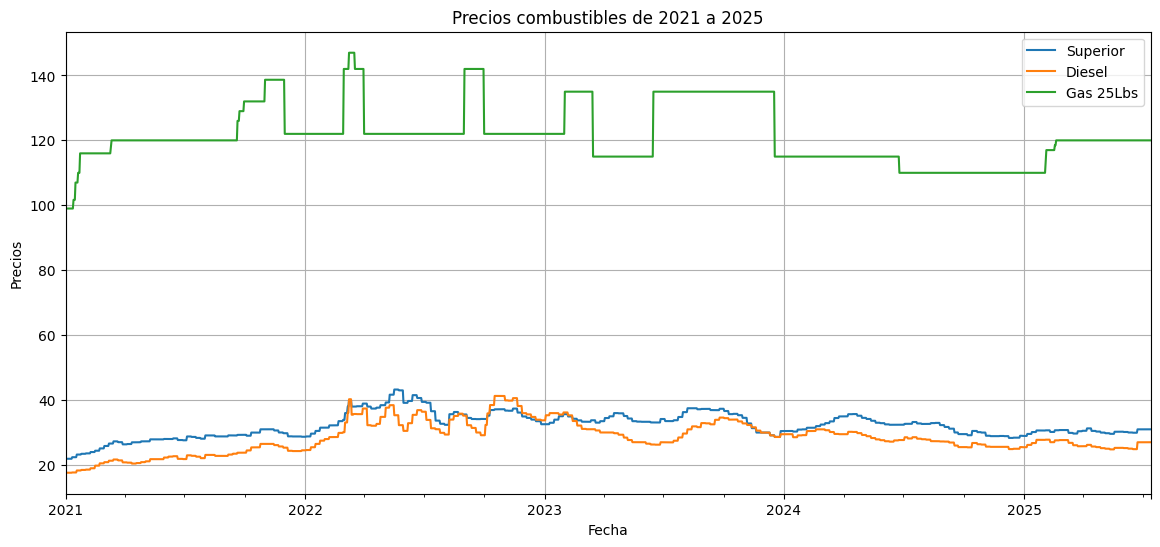

In [235]:
df_final.plot(figsize=(14, 6), y=['Superior', 'Diesel', 'Gas 25Lbs'], title="Precios combustibles de 2021 a 2025")
plt.ylabel("Precios")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

A continuación, también se condujo tests de normalidad sobre los precios de los combustibles, en ninguno de los casos se determinó que un combustible tuviera una distribución normal de precios, sino que era mucho más esporádico.

In [236]:
for col in ["Superior", "Diesel", "Gas 25Lbs"]:
    stat, p = shapiro(df_final[col].dropna())
    print(f"{col}: p = {p}")
    if p > 0.05:
        print("  -> Likely normal")
    else:
        print("  -> Not normal")

Superior: p = 3.9915074748457513e-10
  -> Not normal
Diesel: p = 4.887717605412204e-11
  -> Not normal
Gas 25Lbs: p = 3.252932875953924e-31
  -> Not normal


También se decidio estudiar los meses con precios promdio más alto a lo largo de los años, para descubrir si había alguna relación entre diferentes combustibles, sin embargo, a excepción de 2021 entre diesel y gasolina super, no hay coincidencia entre meses, es decir los incrementos en el precio de un combustible van de la mano con el aumento en el precio de los otros. La tabla a continuación resume los meses de mayor costo promedio para cada año y combustible:

In [237]:
monthly_avg = df_final.groupby(["Año", "Month"])[["Diesel", "Superior", "Gas 25Lbs"]].mean()
max_months = monthly_avg.groupby("Año").idxmax()
max_months

,Diesel,Superior,Gas 25Lbs
Año,,,
2021,"(2021, 11)","(2021, 11)","(2021, 11)"
2022,"(2022, 11)","(2022, 5)","(2022, 3)"
2023,"(2023, 1)","(2023, 8)","(2023, 2)"
2024,"(2024, 2)","(2024, 4)","(2024, 1)"
2025,"(2025, 2)","(2025, 7)","(2025, 3)"


Por último, en la misma linea de estudio sobre los picos en los precios, se calculo los 3 meses con mayores picos en cada año. Estas son las concluciones descubiertas:

- Diesel: De 2021 a 2022, tenia sus picos a finales de año, mientras que para el resto de años los picos ocurrian a principio de año.
- Gasolina: No hay una epoca del año común donde los precios aumenten, sin embargo los meses pico suelen ser cercanos.
- Gas licuado: La alza de precios suele ocurrir a principios de año.

In [238]:
top3_months_per_year = {}

for year, group in monthly_avg.groupby(level=0):  # level=0 is Year
    top_months = {}
    for fuel in ["Diesel", "Superior", "Gas 25Lbs"]:
        top_months[fuel] = group[fuel].nlargest(3)
    top3_months_per_year[year] = top_months

In [239]:
import calendar

for year, fuels in top3_months_per_year.items():
    print(f"\nYear {year}")
    for fuel, series in fuels.items():
        print(f"  {fuel}:")
        for (y, m), val in series.items():
            month_name = calendar.month_name[m]
            print(f"    {month_name} ({m}): {val:.2f}")


Year 2021
  Diesel:
    noviembre (11): 26.14
    octubre (10): 25.29
    diciembre (12): 24.50
  Superior:
    noviembre (11): 30.59
    octubre (10): 29.92
    septiembre (9): 29.11
  Gas 25Lbs:
    noviembre (11): 138.67
    octubre (10): 132.00
    septiembre (9): 123.10

Year 2022
  Diesel:
    noviembre (11): 39.29
    octubre (10): 38.29
    marzo (3): 35.69
  Superior:
    mayo (5): 41.45
    junio (6): 40.20
    abril (4): 37.98
  Gas 25Lbs:
    marzo (3): 143.45
    septiembre (9): 142.00
    enero (1): 122.00

Year 2023
  Diesel:
    enero (1): 35.62
    febrero (2): 33.93
    octubre (10): 33.89
  Superior:
    agosto (8): 37.15
    septiembre (9): 37.10
    octubre (10): 35.80
  Gas 25Lbs:
    febrero (2): 135.00
    julio (7): 135.00
    agosto (8): 135.00

Year 2024
  Diesel:
    febrero (2): 30.48
    marzo (3): 30.07
    abril (4): 29.87
  Superior:
    abril (4): 35.31
    marzo (3): 33.79
    mayo (5): 33.63
  Gas 25Lbs:
    enero (1): 115.00
    febrero (2): 115.00

**Influencia de pandemia**
Con la llegada de pandemia y la reclución de mayoría de actividades a ser realizadas dentro de casa, la necesidad de movilizarse y por tanto de combustibles fósiles llevo a mínimos históricos, lo cual se ve claramente reflejado en las gráficas de precios de todos los combustibles al tener los menores precios entre 2021 y 2022.

Fue con la llegada de las primeras vacunas a inicios de 2023 que muchas actividades laborales volvieron a la normalidad, aumentando el precio de los combustibles.

**Influencia de la guerra de Ucrania**

Justo después de pandemia, a inicios de 2022 la guerra entre Rusia y Ucranía explotó, en pleno hervor de este conflicto Rusia cerro la exportación de combustibles para muchos países, resultando en una escases marcada y llevando al alza de precios históricos.

Se puede concluir que tanto **pandemia como la guerra de ucrania** marcaron tendencias atípicas en los precios, y que seguramente afectará la calidad de predicciones de algunos modelos.

## Series de tiempo

### Precios de Gasolina Super

#### Análisis

A continuación se encuentra el análisos de los precios de la gasolina super, empezando por información básica sobre dichas series:

|INICIO | FIN | Registros totales | 
|-------|-----|------|
|1/1/2021 | 13/6/2025 | 1655

Empezando por una descomposición de la serie (siguiente figura) se puede descubrir patrones poco claros. Como se discutió antes los precios durnate 2021 son anómalos al ser en gran medida influenciados por la pandemia Covid-19; seguido de un pico histórico que coincide con el embargo de Rusia en combustibles fósiles; **ambos sucesos no recurrentes, que afectan la variabilidad del modelo y la facilidad para determinar estacionaridad en la misma**.

Esto se ve reflejado en la sección de "Trend" como un valle histórico seguido de un pico, que ha ido descreciendo a lo largo de los años.

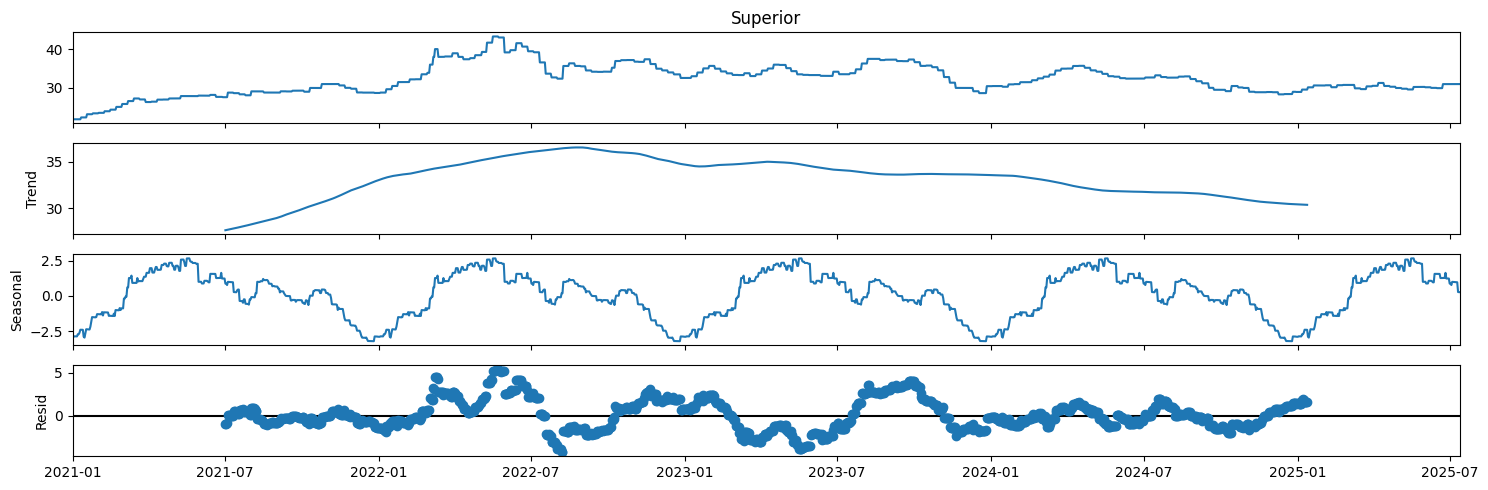

In [240]:
descomposicion = seasonal_decompose(df_final["Superior"], period=365)
descomposicion.plot();

Este segundo gráfico muestra como la media y varianza móvil distan mucho ser consante al verse afectada por los valles y picos causados por la pandemia y la guerra.

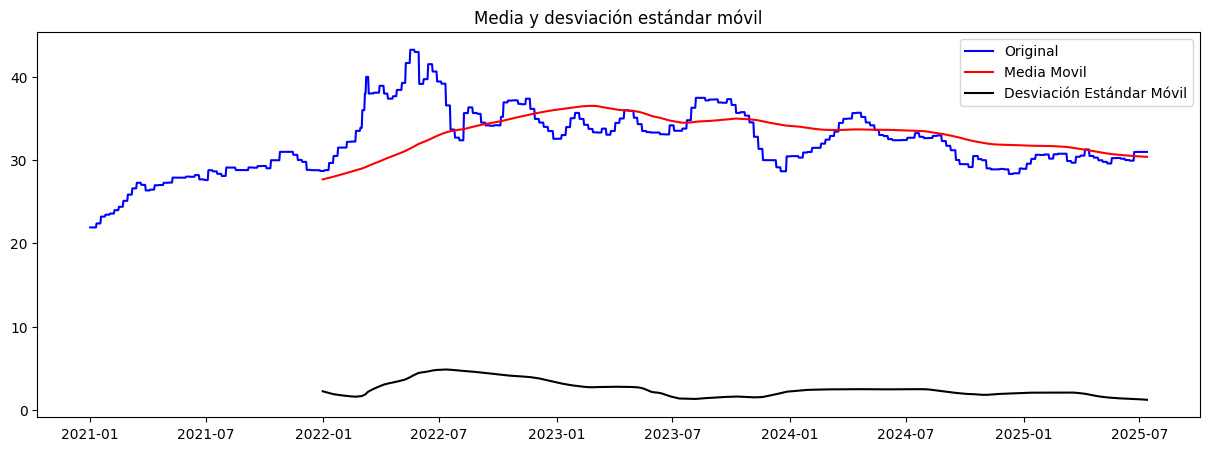

In [241]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df_final["Superior"].rolling(window=365).mean()
deMovil = df_final["Superior"].rolling(window=365).std()
# Se grafican los resultados.
original = plt.plot(df_final["Superior"], color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

**Frecuencias**

Un análisis de frecuencias por medio de histograma nos revela los precios más frecuentes a lo largo de los 4 se encuentra entre el rango de Q29.00 a Q34.00, además de una distribución no normal.

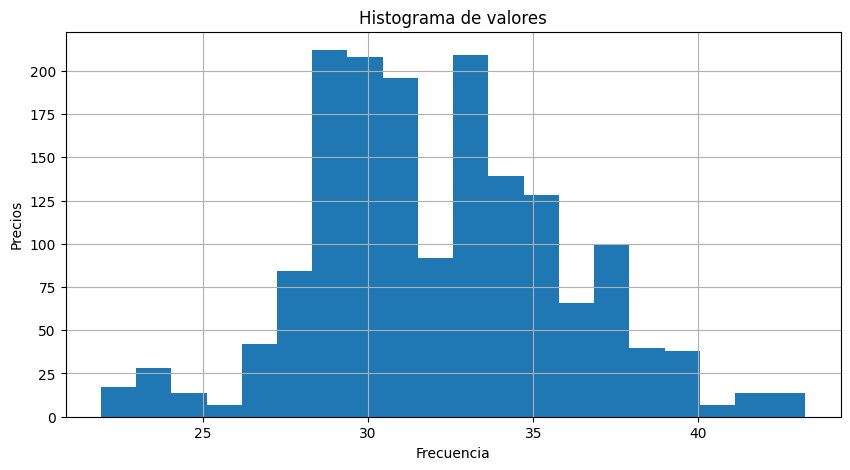

In [242]:
df_final["Superior"].plot(kind="hist", figsize=(10, 5), title="Histograma de valores", bins=20)
plt.xlabel("Frecuencia")
plt.ylabel("Precios")
plt.grid(True)
plt.show()

De los gráficos anteriores se puede disnernir que la serie no parece ser estacionaria ni en media o varianza, un análisis más profundo tendrá que llevarse a cabo.

### Determinación de Estacionaridad

**Estacionaridad en varianza**

De la exploración previa se descubrió que la varianza podría no ser constante, lo cual es confirmado por los 3 tests estadísticos siguientes donde indican heterocedasticidad cuando p < 0.05. Es por ello que se aplicará una transformación de boxcox para suavizar dicha varianza.


In [243]:
resultados = Heteroskedasticity.run_all_tests(df_final['Superior'])
df_results = pd.DataFrame(list(resultados.items()), columns=['Test', 'p-value'])
df_results

,Test,p-value
0,White,4.925573e-50
1,Breusch-Pagan,3.862808e-47
2,Goldfeld-Quandt,6.786014e-55


In [244]:
transformed, fitted_lambda = boxcox(df_final["Superior"])
df_final.loc[df_final.index, "Superior-fixed"] = transformed

Se puede ver una reducción notable en la variana a lo largo de la series antes y después de boxcox.

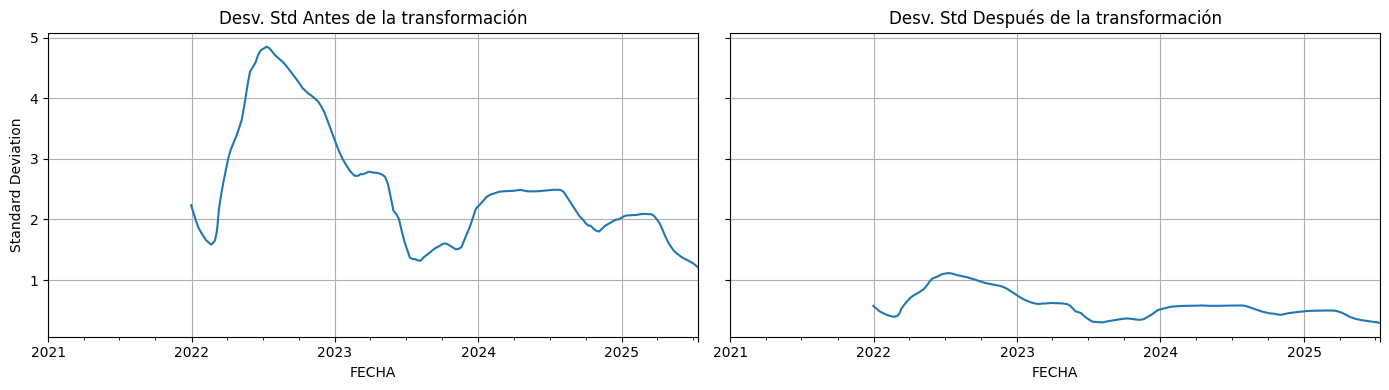

In [245]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Plot first rolling std dev
df_final['Superior'].rolling(window=365).std().plot(ax=axes[0], title="Desv. Std Antes de la transformación")
axes[0].set_ylabel("Standard Deviation")
axes[0].grid(True)

# Plot second rolling std dev
df_final['Superior-fixed'].rolling(window=365).std().plot(ax=axes[1], title="Desv. Std Después de la transformación")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Sin embargo, los tests siguen siendo fallidos, esto puede ser causado por la variabilidad "artificial" introducida por la pandemia y la guerra. Sin embargo, se mantendrá la transformación dado que la figure previa muestra una atenuación en los picos y valles de la misma.

In [246]:
resultados = Heteroskedasticity.run_all_tests(df_final['Superior-fixed'])
df_results = pd.DataFrame(list(resultados.items()), columns=['Test', 'p-value'])
df_results

,Test,p-value
0,White,1.737177e-55
1,Breusch-Pagan,1.115240e-49
2,Goldfeld-Quandt,1.421570e-52


**Estacionaridad en media**

De lo visto en el análisis exploratorio, la media tampoco se mostraba constante teniendo un ritmo creciente hasta 2022 donde la tendencia se volvio decreciente. Esto es reforzado viendo el correlograma donde la correlación cae lenta y continuamente, siendo indicio de **no estacionariedad en media.**

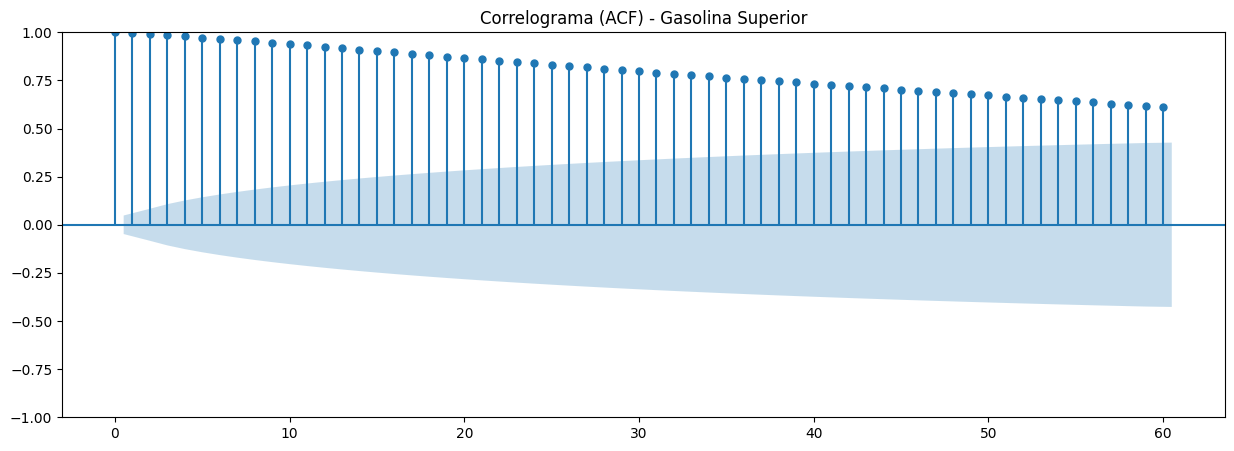

In [247]:
series = df_final["Superior"]

# Plot correlogram (ACF plot)
plot_acf(series, lags=60)
plt.title("Correlograma (ACF) - Gasolina Superior")
plt.show()

Por otro lado, el test de Dicker Fuller al tener un p < 0.05 indica hay estacionaridad en media.

In [248]:

print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df_final["Superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Resultados del Test de Dickey Fuller


Estadístico de prueba          -3.097852
p-value                         0.026713
# de retardos usados            7.000000
# de observaciones usadas    1647.000000
Critical Value (1%)            -3.434327
Critical Value (5%)            -2.863296
Critical Value (10%)           -2.567705
dtype: float64

Un segundo test estadistitico KPSS, al tener un p < 0.5 da positivo para heterocedasticidad. Juntanto todas las pruebas, se considera que **no estacionaridad en media, por lo que habrá que diferenciar la serie.**

In [249]:
# Run KPSS test
stat, p_value, lags, crit = kpss(df_final["Superior"].values, regression="ct")

# Prepare dictionary
kpss_result = {
    "Test Statistic": stat,
    "p-value": p_value,
    "Lags Used": lags,
    **{f"Critical Value ({k})": v for k, v in crit.items()}
}


df_results = pd.DataFrame(list(kpss_result.items()), columns=['Parametro', 'valor'])
df_results

/tmp/ipykernel_75876/1074177925.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(df_final["Superior"].values, regression="ct")


,Parametro,valor
0,Test Statistic,0.990497
1,p-value,0.010000
2,Lags Used,26.000000
3,Critical Value (10%),0.119000
4,Critical Value (5%),0.146000
5,Critical Value (2.5%),0.176000
6,Critical Value (1%),0.216000


Tras la diferenciacion, ambos test estadísticos dieron positivo para homocedasticidad. Sin embargo el test KPSS todavía se encuentra cerca de la frontera para ser considerado heterecedastico, así que se podria diferenciar 2 a 4 veces.

In [250]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df_final["Superior"].diff().dropna(), autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Resultados del Test de Dickey Fuller


Estadístico de prueba       -1.119726e+01
p-value                      2.290085e-20
# de retardos usados         6.000000e+00
# de observaciones usadas    1.647000e+03
Critical Value (1%)         -3.434327e+00
Critical Value (5%)         -2.863296e+00
Critical Value (10%)        -2.567705e+00
dtype: float64

In [251]:
# Run KPSS test
stat, p_value, lags, crit = kpss(df_final["Superior"].diff().dropna().values, regression="ct")

# Prepare dictionary
kpss_result = {
    "Test Statistic": stat,
    "p-value": p_value,
    "Lags Used": lags,
    **{f"Critical Value ({k})": v for k, v in crit.items()}
}


df_results = pd.DataFrame(list(kpss_result.items()), columns=['Parametro', 'valor'])
df_results

/tmp/ipykernel_75876/3976747430.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, lags, crit = kpss(df_final["Superior"].diff().dropna().values, regression="ct")


,Parametro,valor
0,Test Statistic,0.070164
1,p-value,0.100000
2,Lags Used,4.000000
3,Critical Value (10%),0.119000
4,Critical Value (5%),0.146000
5,Critical Value (2.5%),0.176000
6,Critical Value (1%),0.216000


### Generación de modelos

**Creacion de conjuntos de prueba**

Se utilizaron como conjunto de test todos los datos de 2025, el resto de datos fueron para entrenamiento.

In [252]:
df_train = df_final[(df_final.index.year > 2020) & (df_final.index.year < 2025)]
df_test = df_final[df_final.index.year >= 2025]


**SARIMAX**

En base a lo estudiado en la sección anterior, la serie será transformada con coxbox seguido de 1 a 3 diferenciaciónes. Sin embargo, primero hay que decidir los valores de `p` y `q` usando las gráficas ACF y PACF.

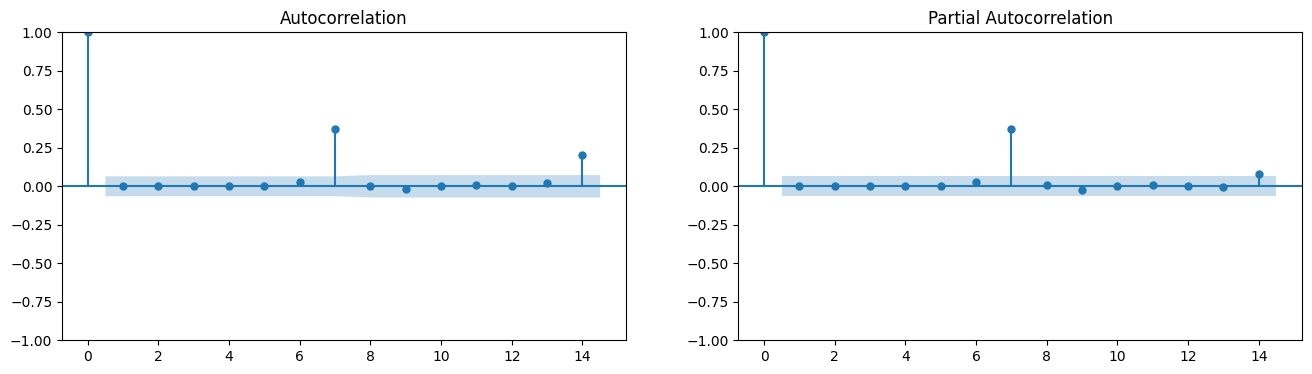

In [253]:
series = df_final[df_final.index.year > 2022]['Superior'].diff().dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series, lags=14, ax=ax[0])
plot_pacf(series, lags=14, ax=ax[1])
plt.show()

Los gráficos muestran cortes abruptos después del primer retardo, por lo que p=1 y q=1. 

**Estacionariedad**

De los gráficos ACF y PACF anteriores se pueden apreciar pequeños picos que sobresalen cada 7 lags, por lo que se harán unos nuevos gráficos ACF y PACF considerando ese componente estacional. De las nuevas figuras tambien se deduce un corte después de 1 lag P = 1, D = 1.

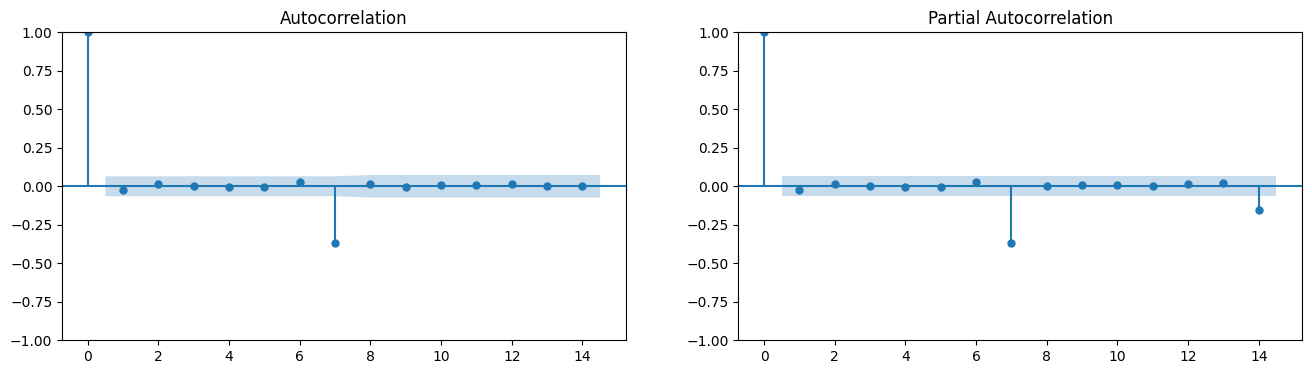

In [254]:
series = df_final[df_final.index.year > 2022]['Superior'].diff().diff(7).dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series, lags=14, ax=ax[0])
plot_pacf(series, lags=14, ax=ax[1])
plt.show()

Con eso listo, se creo un modelo SARIMAX, con los siguientes resultados:

In [255]:
df_final["event_2020_2022"] = ((df_final.index >= "2020-01-01") & (df_final.index <= "2022-12-31")).astype(int)

df_train = df_final[(df_final.index.year > 2020) & (df_final.index.year < 2025)]
df_test = df_final[df_final.index.year >= 2025]

exog_train = df_train[["event_2020_2022"]]

modelo121 = SARIMAX(
    df_train['Superior-fixed'], 
    order=(1,2,1), 
    seasonal_order=(0,1,0,7), 
    enforce_stationarity=False, 
    enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])
print("AIC:", resultado_m121.aic)
print("BIC:", resultado_m121.bic)

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0244      0.024     -1.007      0.314      -0.072       0.023
ma.L1         -1.0000      3.150     -0.317      0.751      -7.174       5.174
sigma2         0.0075      0.024      0.317      0.751      -0.039       0.054
AIC: -2974.412537696233
BIC: -2958.574581189989


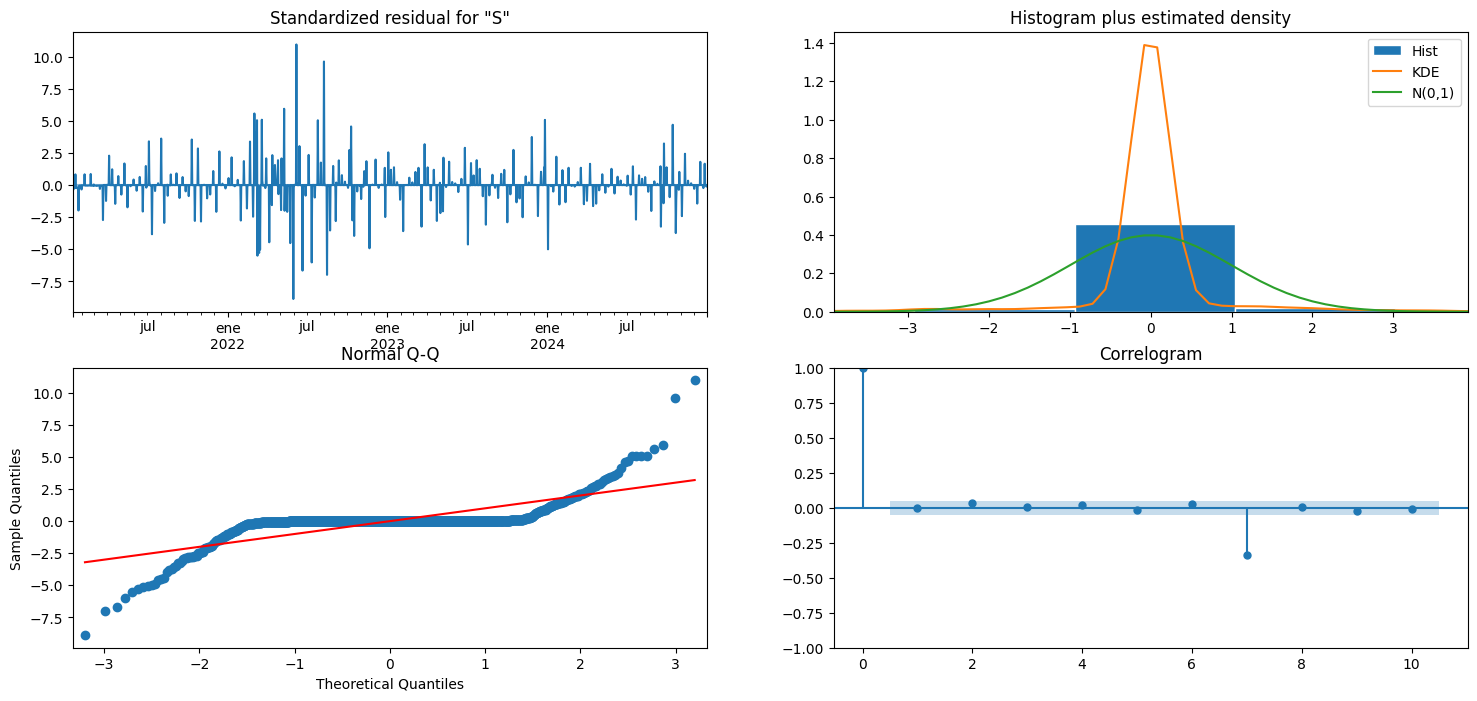

In [256]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

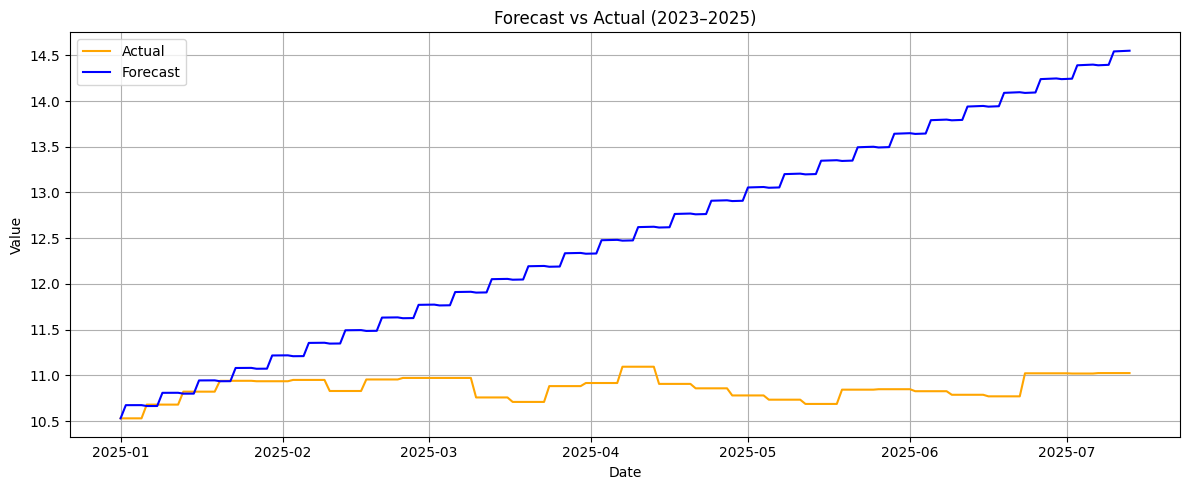

In [257]:
pred = resultado_m121.get_forecast(steps=len(df_test))
predicted_mean = pred.predicted_mean

# Subset predictions and test data to 2023–2025
start_date = "2023-01-01"
end_date = "2025-12-31"

# Filter test set and forecast results
pred_index = df_test.index  # Forecast index matches test set
forecast_series = pd.Series(predicted_mean.values, index=pred_index)
conf_int = pred.conf_int()

# Slice to desired date range
forecast_series = forecast_series[start_date:end_date]
conf_int = conf_int.loc[start_date:end_date]
actual_test = df_test['Superior-fixed'][start_date:end_date]

plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test, label='Actual', color='orange')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='blue')
plt.title("Forecast vs Actual (2023–2025)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se puede observar que el modelo solo pudo ajustarse durante la primera mitad del mes, sin embargo el resto de las predicciones distan mucho de lo esperado indicando que el modelo no puedo atrapar bien los patrones estacionarios de la seria, que pudieron ser en parte encubiertos por los anomalías causadas por la pandemia y guerra de Ucrania.

**Prophet**

In [258]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet_train = df_train.reset_index()[['FECHA', 'Superior-fixed']]
df_prophet_train.columns = ['ds', 'y']

# Fit model
model = Prophet()
model.fit(df_prophet_train)


# Forecast
periods = (df_test.index[-1] - df_test.index[0]).days + 1
future = model.make_future_dataframe(periods=periods)
forecast = model.predict(future)

17:29:19 - cmdstanpy - INFO - Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing


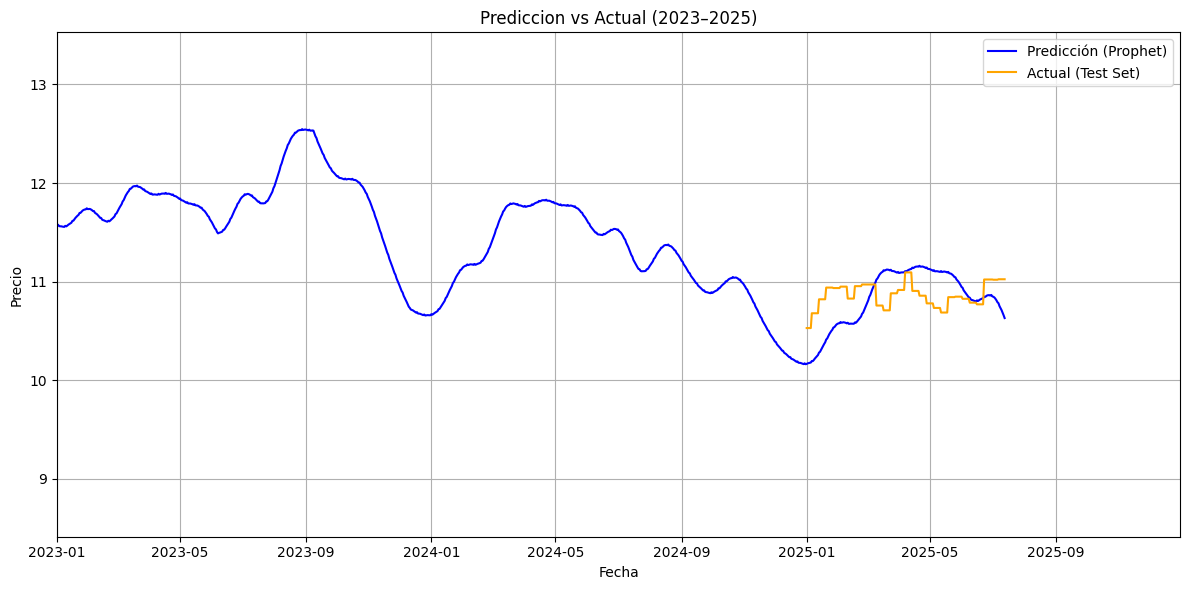

In [259]:
# Step 2: Plot forecast vs actual
plt.figure(figsize=(12, 6))

# Plot forecasted values
plt.plot(forecast['ds'], forecast['yhat'], label='Predicción (Prophet)', color='blue')

# Plot actual test values
plt.plot(df_test.index, df_test['Superior-fixed'], label='Actual (Test Set)', color='orange')

# Formatting
plt.title('Prediccion vs Actual (2023–2025)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-12-31'))

plt.tight_layout()
plt.show()

In [260]:
# Merge forecast and training set
merged = pd.merge(df_prophet_train, forecast[['ds', 'yhat']], on='ds')

# Compute residuals
residuals = merged['y'] - merged['yhat']

# Compute variance of residuals
sigma2 = np.var(residuals)

# Compute log-likelihood assuming Gaussian residuals
n = len(residuals)
log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)

k = 15  # estimated number of parameters (adjust if needed)

aic = 2 * k - 2 * log_likelihood
bic = k * np.log(n) - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

AIC: -463.96
BIC: -384.65


**Holt-Winters**

In [261]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define seasonal period — e.g., 365 for daily data with yearly seasonality
seasonal_period = 180

# Fit Holt-Winters model (additive or multiplicative depending on seasonality type)
hw_model = ExponentialSmoothing(
    df_train['Superior-fixed'],
    trend='add',                  # or 'mul' if multiplicative trend fits better
    seasonal='add',               # or 'mul'
    seasonal_periods=seasonal_period,
    initialization_method="estimated"
).fit()

# Forecast for the length of df_test
y_pred = hw_model.forecast(len(df_test))

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


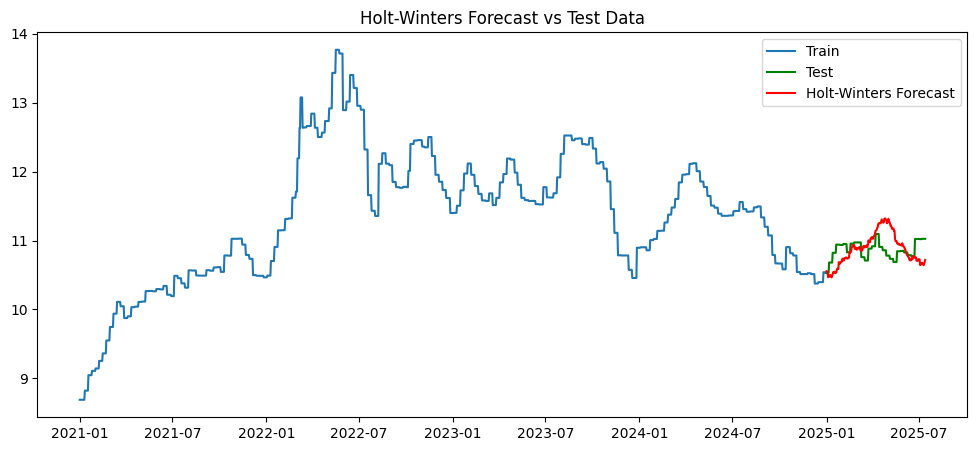

AIC: -7495.76
BIC: -6522.98


In [262]:
plt.figure(figsize=(12, 5))
plt.plot(df_train.index, df_train['Superior-fixed'], label='Train')
plt.plot(df_test.index, df_test['Superior-fixed'], label='Test', color='green')
plt.plot(df_test.index, y_pred, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters Forecast vs Test Data')
plt.legend()
plt.show()

print(f"AIC: {hw_model.aic:.2f}")
print(f"BIC: {hw_model.bic:.2f}")

**Neural networks**

In [263]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Number of lags to use (you can tune this)
N_LAGS = 10

# Transform series to supervised learning format
def create_supervised(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Extract training series
train_series = df_train["Superior-fixed"].values
test_series = df_test["Superior-fixed"].values

# Create supervised data
X_train, y_train = create_supervised(train_series, N_LAGS)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Start with the last N_LAGS values from train
last_window = list(train_series[-N_LAGS:])
predictions = []

for _ in range(len(test_series)):
    X_input = scaler.transform([last_window])
    pred = mlp.predict(X_input)[0]
    predictions.append(pred)
    last_window = last_window[1:] + [pred]  # Slide the window

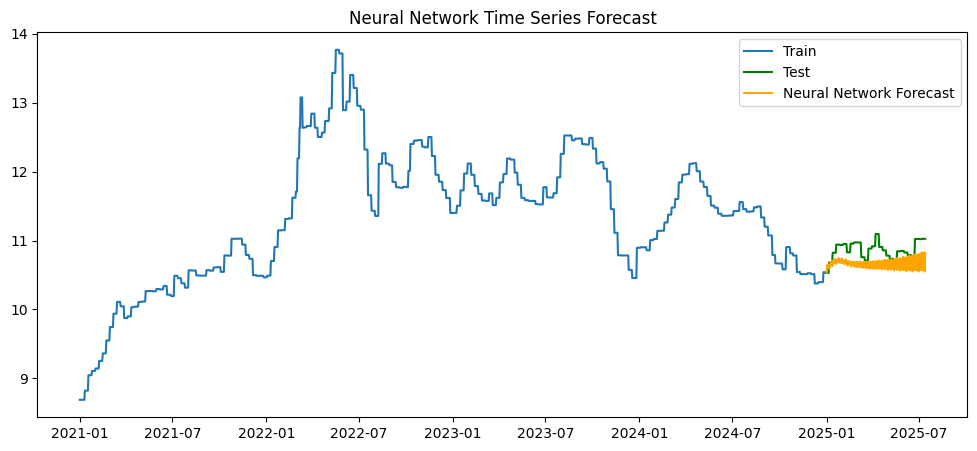

In [264]:
plt.figure(figsize=(12, 5))
plt.plot(df_train.index, df_train['Superior-fixed'], label='Train')
plt.plot(df_test.index, df_test['Superior-fixed'], label='Test', color='green')
plt.plot(df_test.index, predictions, label='Neural Network Forecast', color='orange')
plt.title("Neural Network Time Series Forecast")
plt.legend()
plt.show()

In [265]:
mse = mean_squared_error(df_test["Superior-fixed"], predictions)
n = len(df_test)
k = mlp.hidden_layer_sizes[0] + mlp.hidden_layer_sizes[1] + 1  # rough count of parameters

aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

print(f"AIC (approx): {aic:.2f}")
print(f"BIC (approx): {bic:.2f}")

AIC (approx): -257.80
BIC (approx): 235.65


### Conclusiones

A continuación se muestra una recopilación de los estadísticos AIC y BIC de los diferentes modelos:

| Modelo        | AIC | BIC |
|---------------|-----|-----|
| ARIMAX        | -2974.41 | -2958.57 |
| Prophet       | -463.96 | -384.65 |
| Holt-Winters  | -7495.76 | -6522.98 |
| Redes Neuronales | -257.80 | 235.65 |

El mejor modelo con diferencia fue dado por lo redes neuronales, seguido de ARIMAX, Prophet y Holt-Winters. Sin embargo, todos los modelos erraron bastante del precio original, es importante notar que todos los algoritmos trabajaron con el conjunto de datos transformado por boxcox, su omisión en algunos casos llevaba a resultados incluso más errados.

El precio de combustible esta afectados por muchos factores sociales y económicos pudiendo incurrir en patrones demasiado compolicados e inesperados, el caso de la pandemia y guerra de Ucrania son claro ejemplo al mostrar cambios repentinos, esto puede explicar por que los modelos no lograron adaptarse bien a la serie presentada.

### Consumo de Gasolina

In [266]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gasolina superior"]]


train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data

train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

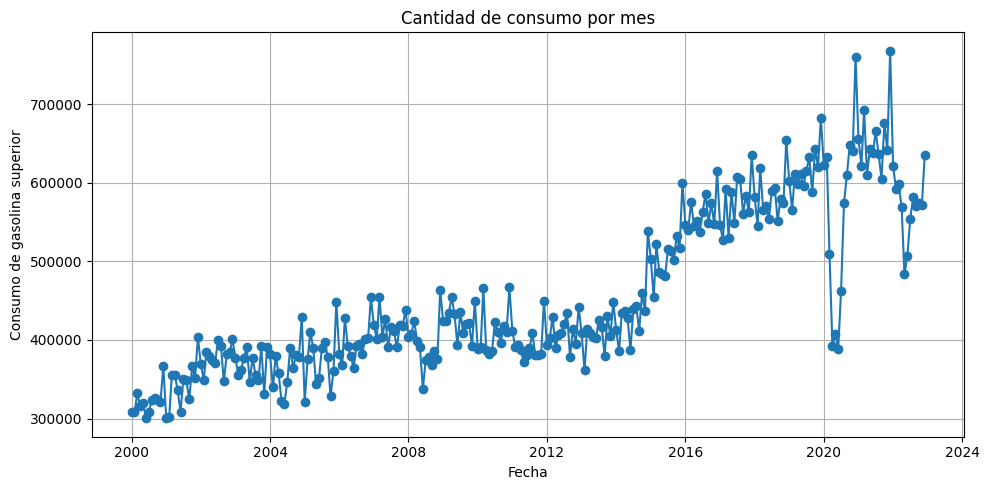

In [267]:
# Graficar solo la columna de consumo
plt.figure(figsize=(10, 5))
plt.plot(train_data["Gasolina superior"], marker='o')

plt.title("Cantidad de consumo por mes")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.grid(True)
plt.tight_layout()
plt.show()


Existe una tendencia creciente en la grafica con un caida muy abrupta a inicio del año 2020 posiblemente ocasionada por el inicio de la pandemia. Se puede ver levemenete como exisen picos cada ciertos puntos que son mas altos que los demas esto posiblemente puede ser que exista algun tipo de estacionalidad y a medida que avanza la grafica se ve como la varianza es creciente y no siempre es igual.

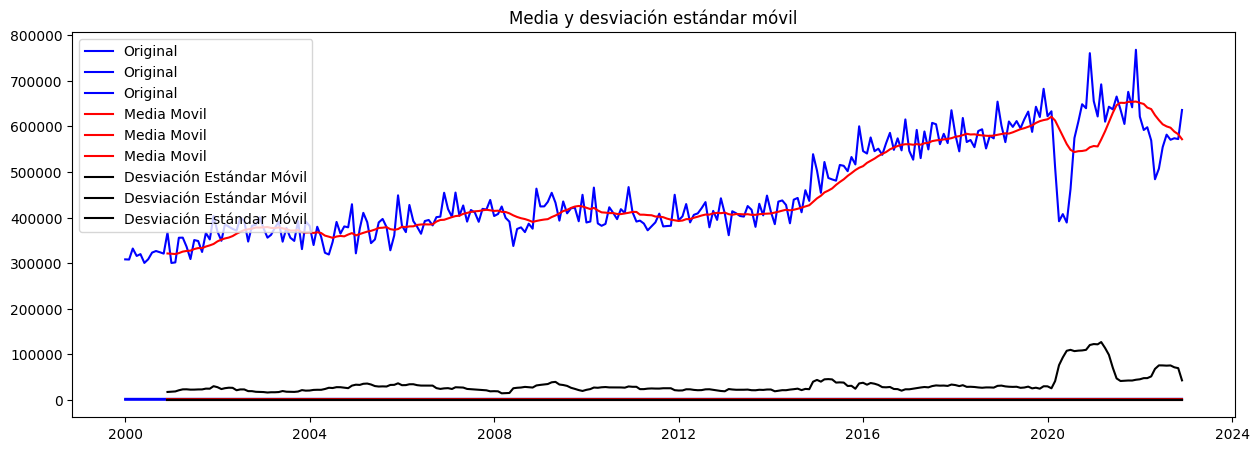

In [268]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = train_data.rolling(window=12).mean()
deMovil = train_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(train_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Se puede evidenciar una tendecia creciente en cuanto a el consumo de gasolina super, evitando el año 2020 el cual es un dato bastante atipoco para el modelo. la desviacion estandar es bastante constante hasta el año 2020 el cual hay un salto abrupto en cuando a la varianza.

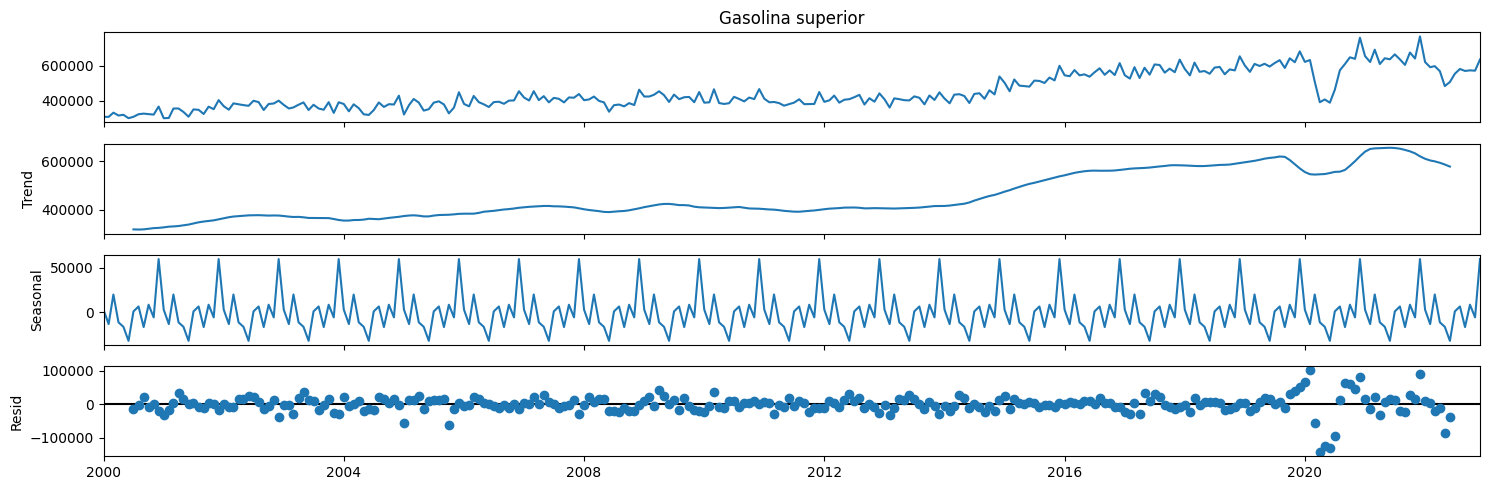

In [269]:
descomposicion = seasonal_decompose(train_data["Gasolina superior"])
descomposicion.plot();

Se puede ver cierta tendencia creciente no constante, se puede ver estacionalidad clara que se repite todos los meses. Los residuos parecen ser constante hasta 2020 donde se comportan de manera aleatoria. Con todo esto se puede afirmar que la grafica es no es estacionaria en media y solo por el año 2020 se comporta no estacionaria en varianza.

In [270]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gasolina superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.268840
p-value                        0.643305
# de retardos usados          12.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


Se puede observar como el valor de p es bastante alto mayor a 0.05 por lo tanto la hipotesis nula no es estacionaria en media. Aplicamos diferenciacion y logaritmo para ver si alguna hace que se vuelva estacionaria

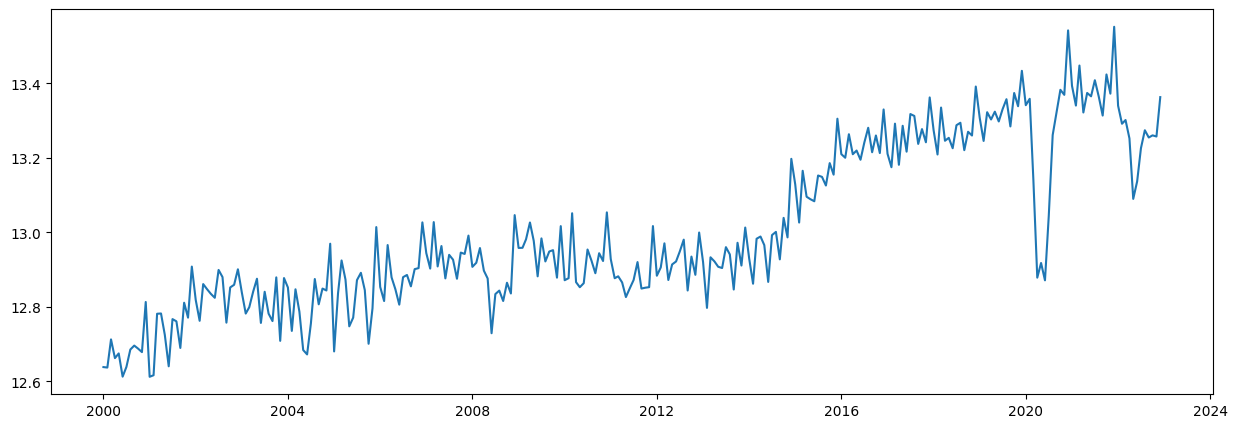

In [271]:
ts_air_pas_log = np.log(train_data["Gasolina superior"])
plt.plot(ts_air_pas_log)

In [272]:
# Aplicar logaritmo
ts_log = np.log(train_data["Gasolina superior"])

# Hacer el test ADF sobre la serie logarítmica directamente
adf_log = adfuller(ts_log.dropna())
print("ADF - Logarítmica")
print(pd.Series(adf_log[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas']))


ADF - Logarítmica
Estadístico de prueba         -1.399617
p-value                        0.582460
# de retardos usados          12.000000
# de observaciones usadas    263.000000
dtype: float64


Se puede observar como el logaritmo no ayudo. Por lo tanto sigue siendo no estacionaria en media.

El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [273]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gasolina superior"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -5.787650e+00
p-value                      4.956215e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.630000e+02
Critical Value (1%)         -3.455461e+00
Critical Value (5%)         -2.872593e+00
Critical Value (10%)        -2.572660e+00
dtype: float64


Al ser un valor mas pequeño de 0.05 se puede afierar que se rechaza la hipotesis nula, la serie diferenciada es tacionaria en media

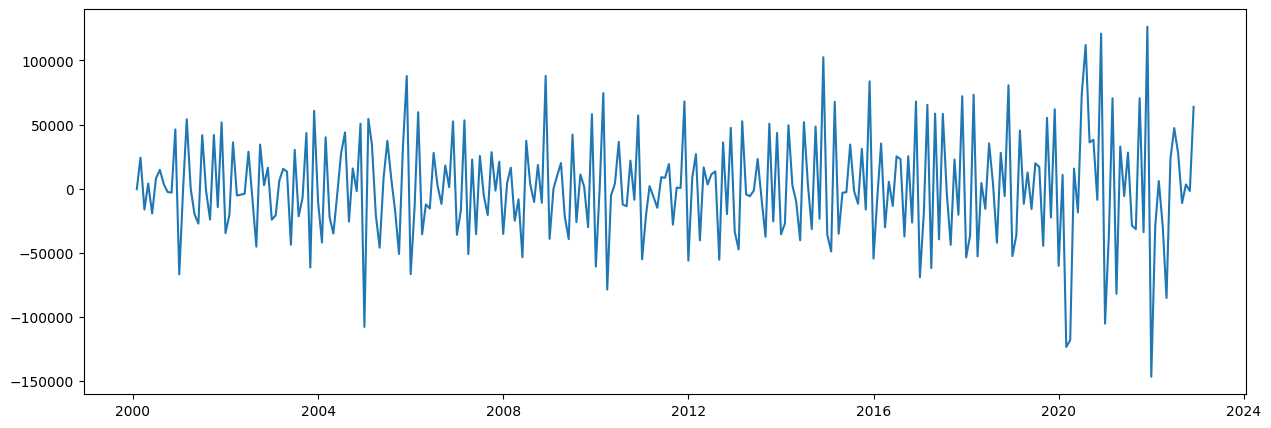

In [274]:
plt.plot(ts_air_pas_diff)

Se puede observar como la seria ahora parace mas estacionaria en media unicamente por los valores del año 2020.

**SARIMAX**

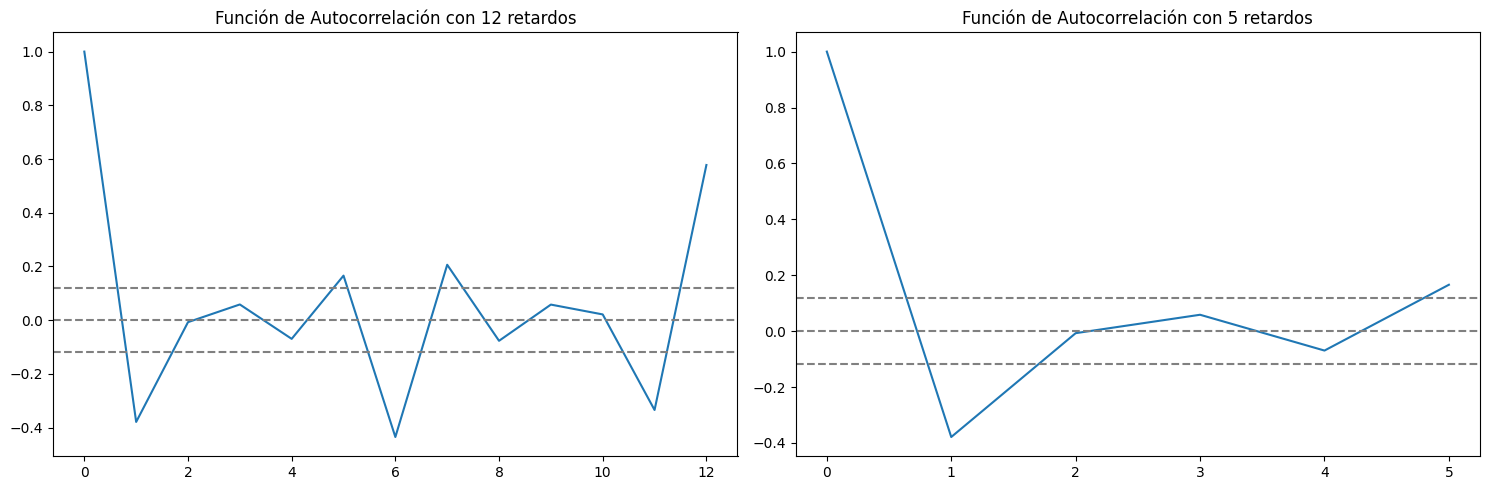

In [275]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_air_pas_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_air_pas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

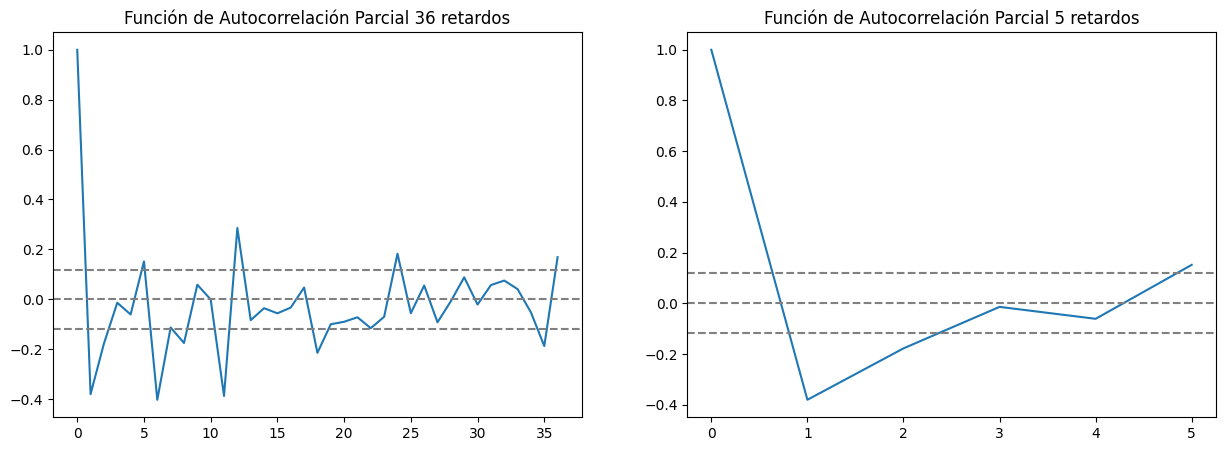

In [276]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_air_pas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_air_pas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA.
Podíamos probar varios modelos ARIMA:
- p=1, q=1
- p=1, q=0
  
En ambos casos solo es necesaria una diferenciación por lo que d=1

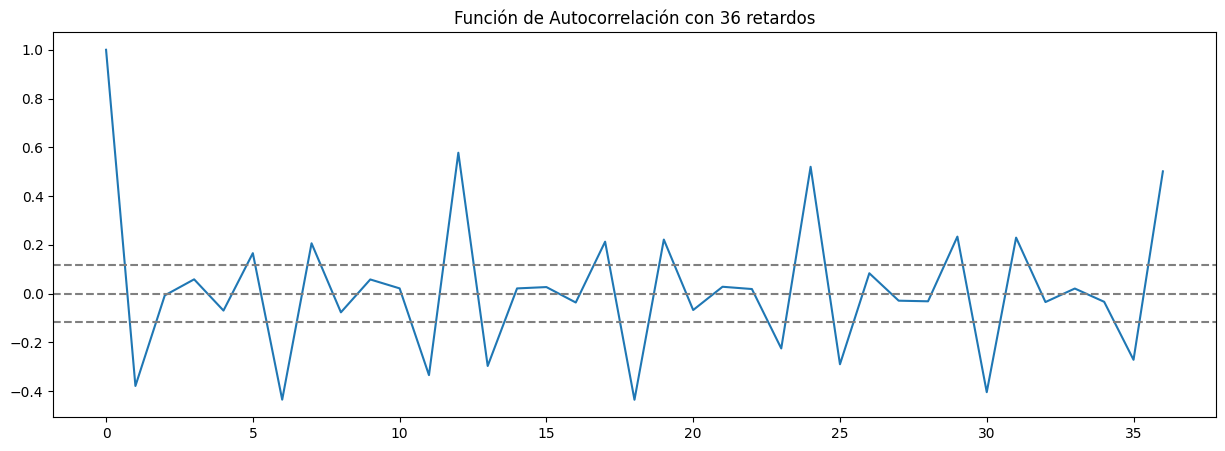

In [277]:
plt.plot(acf(ts_air_pas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar para 12, 24, 36 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Deberíamos agregarle el componente estacional

In [278]:
ts_air_pas_diff_D = ts_air_pas_diff.diff(12)
ts_air_pas_diff_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

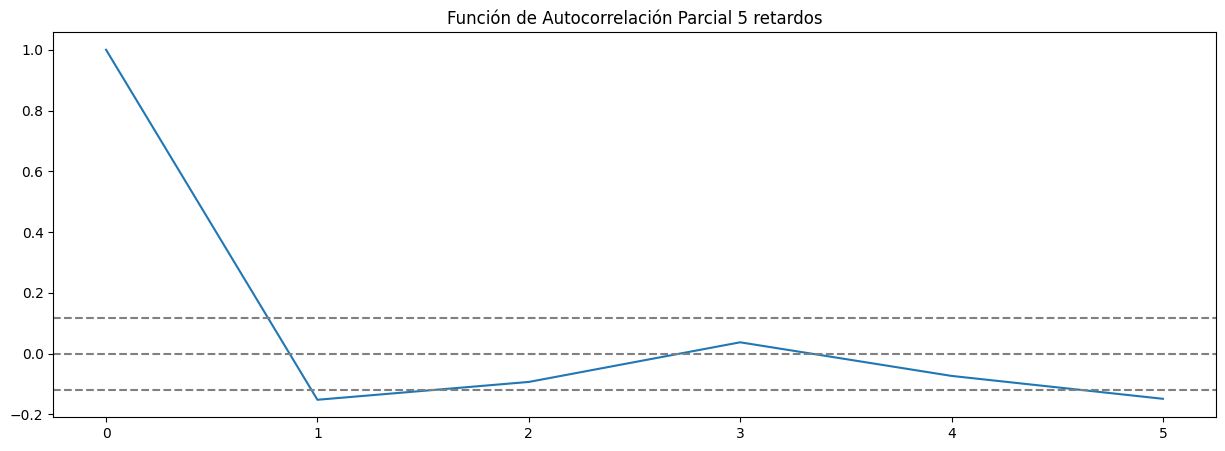

In [279]:
plt.plot(pacf(ts_air_pas_diff_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=2. Probemos el siguiente componente estacional:
- P = 1
- D = 1
- Q = 1

In [280]:
modelo_sarima = SARIMAX(
    ts_air_pas_diff,
    order=(1, 1, 1),                 # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 12),    # SARIMA(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_sarima.fit()

print(resultado_sarima.summary().tables[1])

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2049      0.069     -2.949      0.003      -0.341      -0.069
ma.L1         -0.9891      0.057    -17.255      0.000      -1.101      -0.877
ar.S.L12      -0.1133      0.181     -0.626      0.531      -0.468       0.241
ma.S.L12      -0.7412      0.131     -5.659      0.000      -0.998      -0.484
sigma2      1.763e+09   5.58e-11   3.16e+19      0.000    1.76e+09    1.76e+09


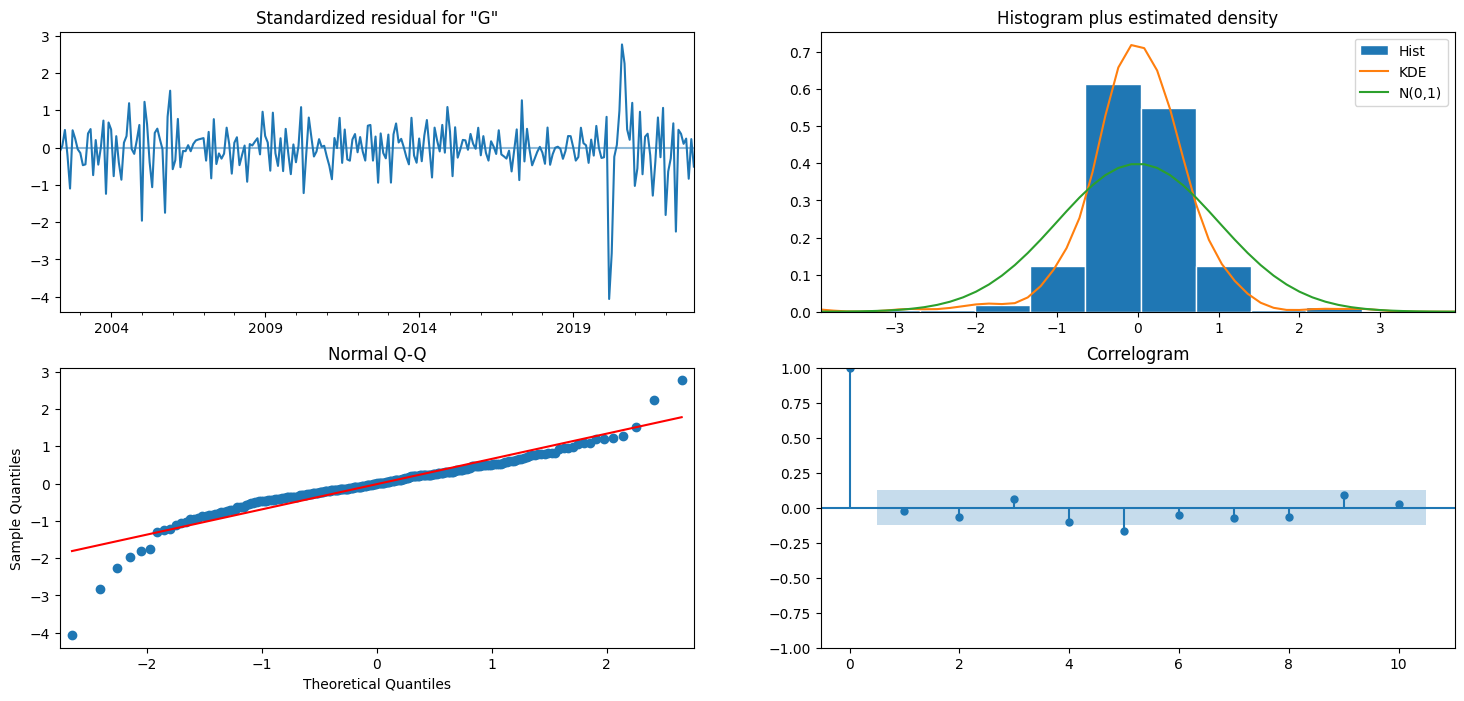

In [281]:
resultado_sarima.plot_diagnostics(figsize=(18, 8))
plt.show()

In [282]:
modelo_2 = SARIMAX(
    ts_air_pas_diff,
    order=(2, 1, 0),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_2 = modelo_2.fit()
print("Modelo SARIMA(2,1,0)(1,1,1,12)")
print(resultado_2.summary().tables[1])

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMA(2,1,0)(1,1,1,12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8276      0.063    -13.038      0.000      -0.952      -0.703
ar.L2         -0.4522      0.071     -6.369      0.000      -0.591      -0.313
ar.S.L12      -0.1324      0.133     -0.998      0.318      -0.393       0.128
ma.S.L12      -0.7418      0.086     -8.642      0.000      -0.910      -0.574
sigma2      1.801e+09   3.44e-11   5.23e+19      0.000     1.8e+09     1.8e+09


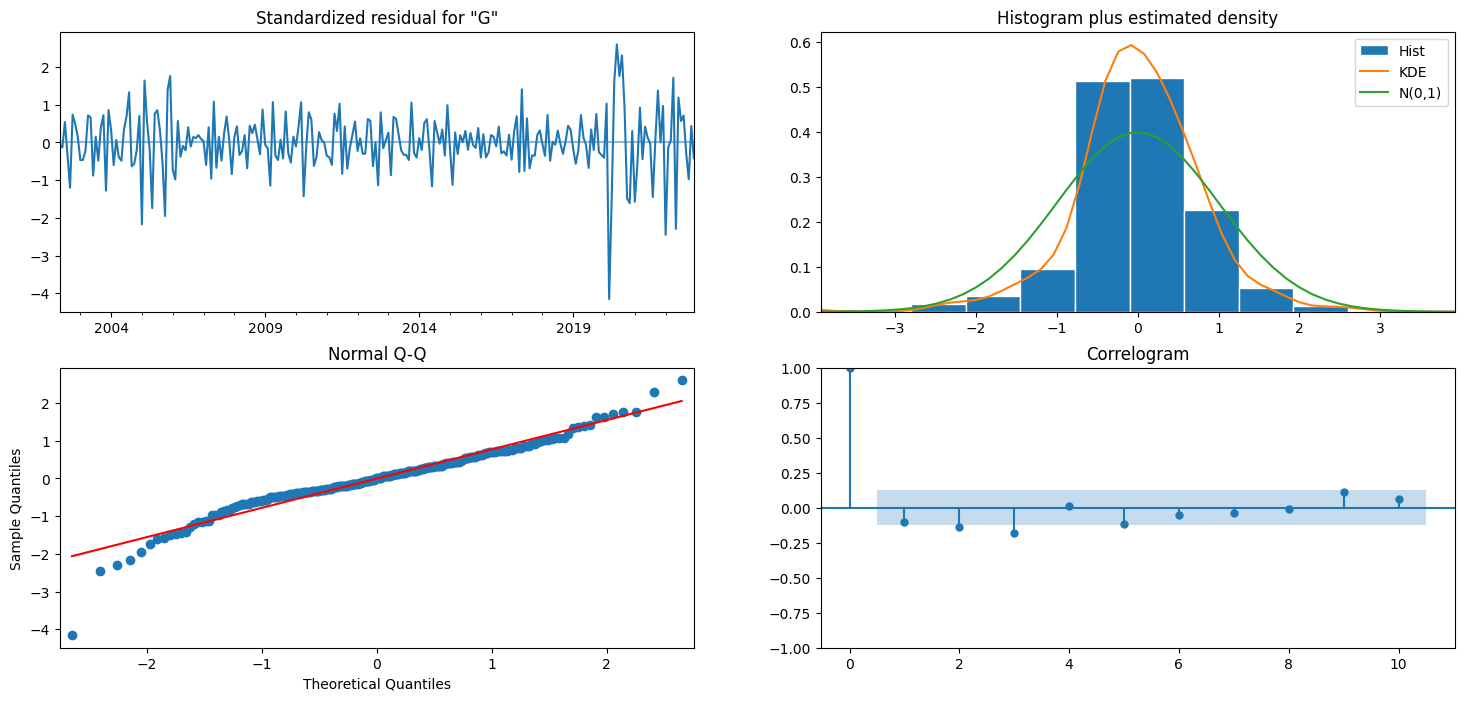

In [283]:
resultado_2.plot_diagnostics(figsize=(18, 8))
plt.show()

In [284]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1=",resultado_sarima.aic)
print("Modelo 2=",resultado_2.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1=",resultado_sarima.bic)
print("Modelo 2=",resultado_2.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1= 5861.609942678233
Modelo 2= 5900.663030151789
Resultados de BIC (Bayesian information criterion)
Modelo 1= 5879.177086409058
Modelo 2= 5918.230173882614


En ambos modelos, la mayoría de los residuos no muestran autocorrelación significativa y se puede observar como ambos modelos son basatnte malos pero el mejor de los seria el primero modelo

In [285]:
hoja_df_2025 = pd.read_excel("./data/VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gasolina superior"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)
test_data.index[0]

Timestamp('2023-01-01 00:00:00')

In [286]:
# Obtener predicciones desde el modelo
pred = resultado_sarima.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_diff = pred.predicted_mean

# Reconstruir valores originales sumando las diferencias al último valor conocido del train
last_train_value = train_data["Gasolina superior"].iloc[-1]
predicted_real = pred_diff.cumsum() + last_train_value

comparison_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Predicción (SARIMA)": predicted_real
})
comparison_df


,Real,Predicción (SARIMA)
2023-01-01,599501.29,561208.378680
2023-02-01,544144.00,536335.018724
2023-03-01,656941.64,556585.387281
2023-04-01,586642.20,499178.612106
2023-05-01,646221.20,501048.929948
2023-06-01,616290.21,490778.156220
2023-07-01,642098.16,530127.430109
2023-08-01,632333.40,548564.134602
2023-09-01,597670.26,527445.148979
2023-10-01,531542.58,565255.015938


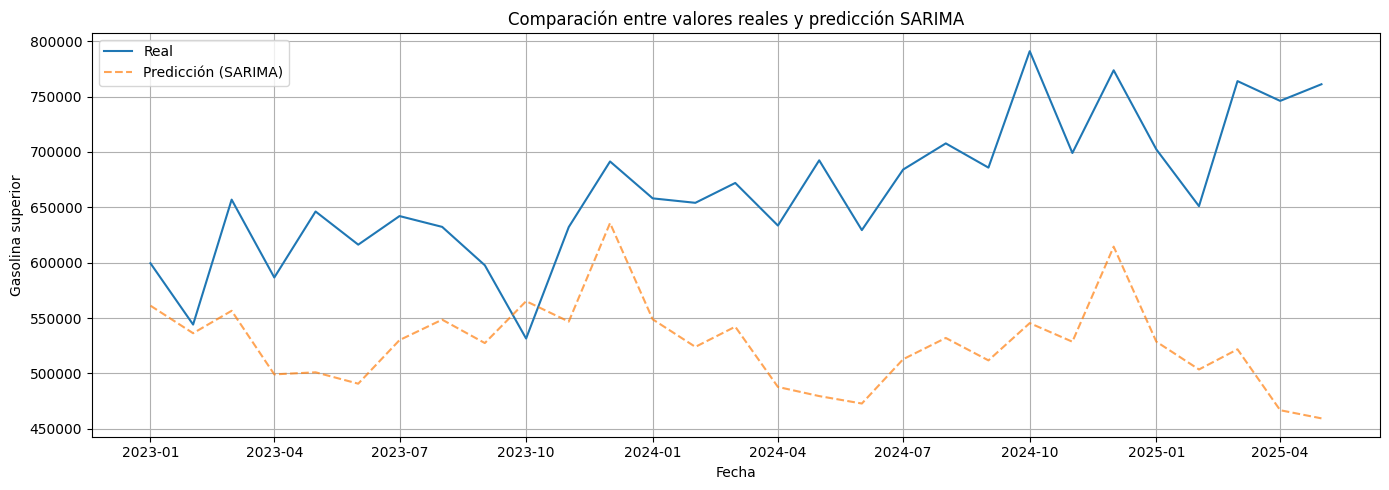

In [287]:
# Asegúrate de que el índice sea tipo datetime para graficar correctamente
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(comparison_df["Real"], label="Real")
plt.plot(comparison_df["Predicción (SARIMA)"], label="Predicción (SARIMA)", linestyle="--", alpha=0.7)
plt.title("Comparación entre valores reales y predicción SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Esto sugiere que el modelo no está capturando bien la magnitud o tendencia ascendente de la serie, lo cual es una señal clara de underfitting. Se puede obsvar como el modelo esta intentando capturar estacionalidad pero no lo logra. El modelo Sarima como esta ahorita no es el adecuado para poder predicir adecuadamente la tendencia. Se podria intentar suvizar el año 2020 porque ese el problema. Haciendo otras pruebas, si agrego el año 2023 a el train este captura de mejor forma la grafica y se asemeja un poco mas pero en la grafica de tendencia se puede observar como el pico final va hacia abajo y el modelo se queda con eso, si se le agrega el año 2023 el pico queda hacia arriba y el modelo por lo tanto sube para arriba.

**Prophet**

In [288]:

from prophet import Prophet
import pandas as pd

df_prophet = train_data.reset_index().rename(columns={"Fecha": "ds", "Gasolina superior": "y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = pd.DataFrame(test_data.index)
future.columns = ['ds']
forecast = model_prophet.predict(future)

pred_prophet = forecast[['ds', 'yhat']].set_index("ds")["yhat"]


17:29:25 - cmdstanpy - INFO - Chain [1] start processing
17:29:25 - cmdstanpy - INFO - Chain [1] done processing


In [289]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar modelo HW
hw_model = ExponentialSmoothing(train_data["Gasolina superior"], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

pred_hw = hw_fit.forecast(steps=len(test_data))
pred_hw.index = test_data.index  

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [290]:
# Normalizar la serie
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[["Gasolina superior"]])

# Función para crear dataset supervisado
def create_supervised(data, lag=12):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Configurar rezago
lag = 12
X_train, y_train = create_supervised(scaled_train, lag)

from sklearn.pipeline import Pipeline

# Definir el pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

# Hiperparámetros a evaluar
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001]
}

# Ejecutar GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid.fit(X_train, y_train)

# Mostrar el mejor modelo
print("Mejores hiperparámetros:", grid.best_params_)


# Predecir paso a paso para todo el período de test
last_input = scaled_train[-lag:].reshape(1, -1)
pred_scaled = []

best_model = grid.best_estimator_

for _ in range(len(test_data)):
    next_scaled = best_model.predict(last_input)[0]
    pred_scaled.append(next_scaled)
    last_input = np.append(last_input[:, 1:], [[next_scaled]], axis=1)

# Inversión del escalado
pred_mlp = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).flatten()
pred_mlp = pd.Series(pred_mlp, index=test_data.index)


comparison_df["MLP (Scikit-learn)"] = pred_mlp

# MAE del nuevo modelo
from sklearn.metrics import mean_absolute_error
print("MAE MLP (Scikit-learn):", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Scikit-learn)"]))



Mejores hiperparámetros: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__solver': 'adam'}
MAE MLP (Scikit-learn): 85825.41288468207


In [291]:
from sklearn.metrics import mean_absolute_error

comparison_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Prophet": pred_prophet,
    "Holt-Winters": pred_hw,
    "MLP (Neuronal)": pred_mlp
})

print(comparison_df)


print("MAE Prophet:", mean_absolute_error(comparison_df["Real"], comparison_df["Prophet"]))
print("MAE Holt-Winters:", mean_absolute_error(comparison_df["Real"], comparison_df["Holt-Winters"]))
print("MAE MLP:", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Neuronal)"]))


                 Real        Prophet   Holt-Winters  MLP (Neuronal)
2023-01-01  599501.29  627778.916969  561177.493867   608209.785106
2023-02-01  544144.00  611634.836258  548955.466294   600832.212616
2023-03-01  656941.64  638842.822348  583914.685726   642505.133407
2023-04-01  586642.20  615691.416011  553909.504174   630841.491039
2023-05-01  646221.20  610741.965016  564821.605379   552335.567972
2023-06-01  616290.21  598901.721931  556895.537517   549863.203299
2023-07-01  642098.16  632477.239673  589189.518738   577161.373164
2023-08-01  632333.40  631140.523272  595168.055864   575973.249989
2023-09-01  597670.26  609525.067371  564389.791350   551953.552465
2023-10-01  531542.58  642617.341339  590924.988736   562597.894843
2023-11-01  632180.03  628745.906508  571815.706078   571761.620940
2023-12-01  691389.62  687427.563616  643695.324943   598375.518879
2024-01-01  658083.66  642501.382641  567657.961082   578172.915799
2024-02-01  654059.60  623460.522887  555435.933

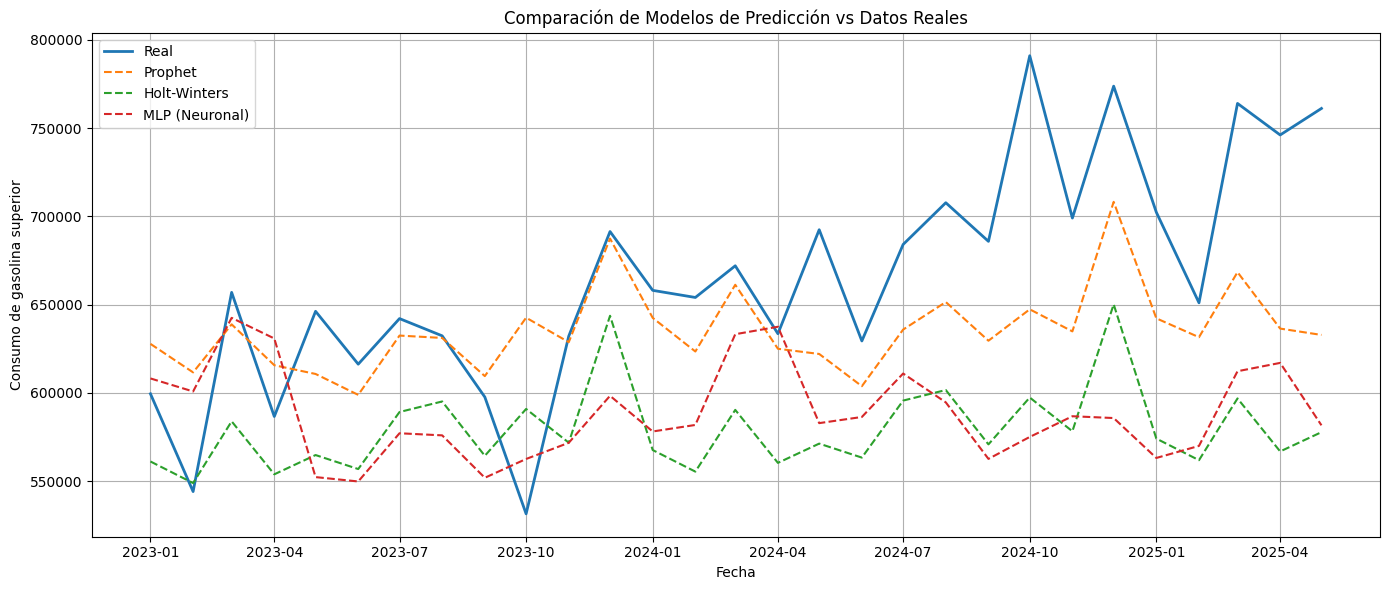

In [292]:
# Asegurarte de que el índice sea de tipo datetime para una buena visualización
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 6))

plt.plot(comparison_df["Real"], label="Real", linewidth=2)
plt.plot(comparison_df["Prophet"], label="Prophet", linestyle="--")
plt.plot(comparison_df["Holt-Winters"], label="Holt-Winters", linestyle="--")
plt.plot(comparison_df["MLP (Neuronal)"], label="MLP (Neuronal)", linestyle="--")

plt.title("Comparación de Modelos de Predicción vs Datos Reales")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusiones**

Comparando el resultado con SARIMA el que mejor logra capturar la tendncia siendo aceptable es el modelo de prophet que se aproxima a lo real , capturando pocos y un mejor balance. En cuanto a los otros en general se puede observar como tienen una mejor capturacion de datos que el modelo de SARIMA. Como mencione con anterioridad el año 2020 si es un golpe bastante fuerte para estos modelos desconcentrandolos y haciendo que aprendan de una mala forma.

### Consumo de Gas Licuado

In [293]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gas licuado de petróleo"]]

hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gas licuado de petróleo"]]

train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gas licuado de petróleo"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data


,Fecha,Gas licuado de petróleo,Año,Mes
0,2000-01-01,194410.476190,2000,1
1,2000-02-01,174710.552381,2000,2
2,2000-03-01,189234.066667,2000,3
3,2000-04-01,174330.607143,2000,4
4,2000-05-01,191745.147619,2000,5
...,...,...,...,...
271,2022-08-01,541273.940000,2022,8
272,2022-09-01,479529.680000,2022,9
273,2022-10-01,545823.450000,2022,10
274,2022-11-01,528393.770000,2022,11


In [294]:
train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

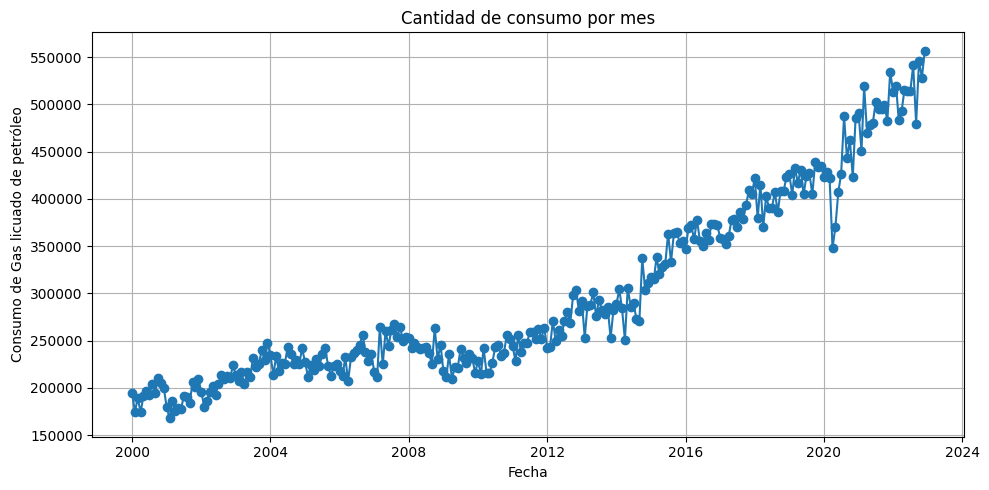

In [295]:
# Graficar solo la columna de consumo
plt.figure(figsize=(10, 5))
plt.plot(train_data["Gas licuado de petróleo"], marker='o')

plt.title("Cantidad de consumo por mes")
plt.xlabel("Fecha")
plt.ylabel("Consumo de Gas licuado de petróleo")
plt.grid(True)
plt.tight_layout()
plt.show()


# Agregar texto aqui xd

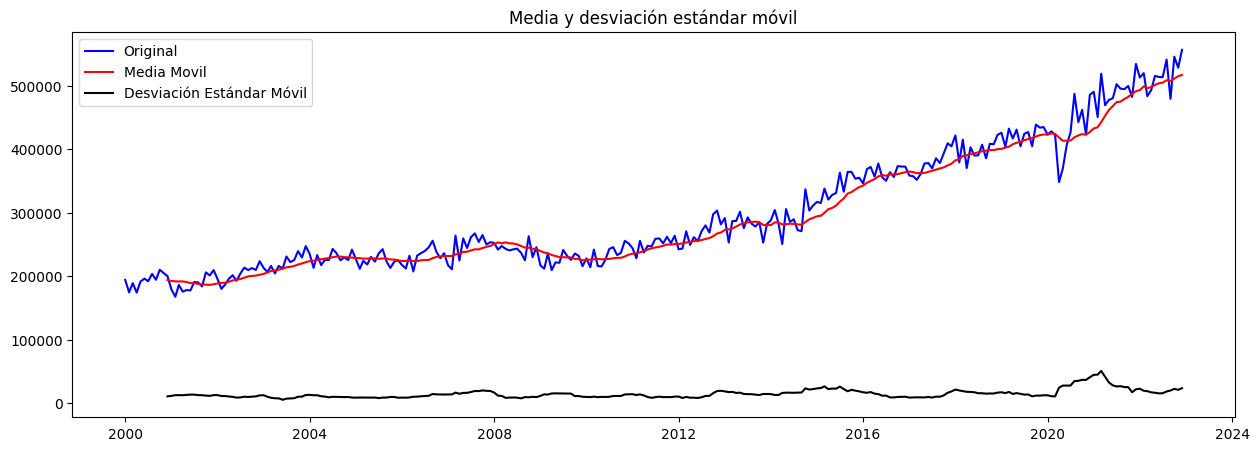

In [296]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = train_data["Gas licuado de petróleo"].rolling(window=12).mean()
deMovil = train_data["Gas licuado de petróleo"].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(train_data["Gas licuado de petróleo"], color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

# Agregar texto aqui xd

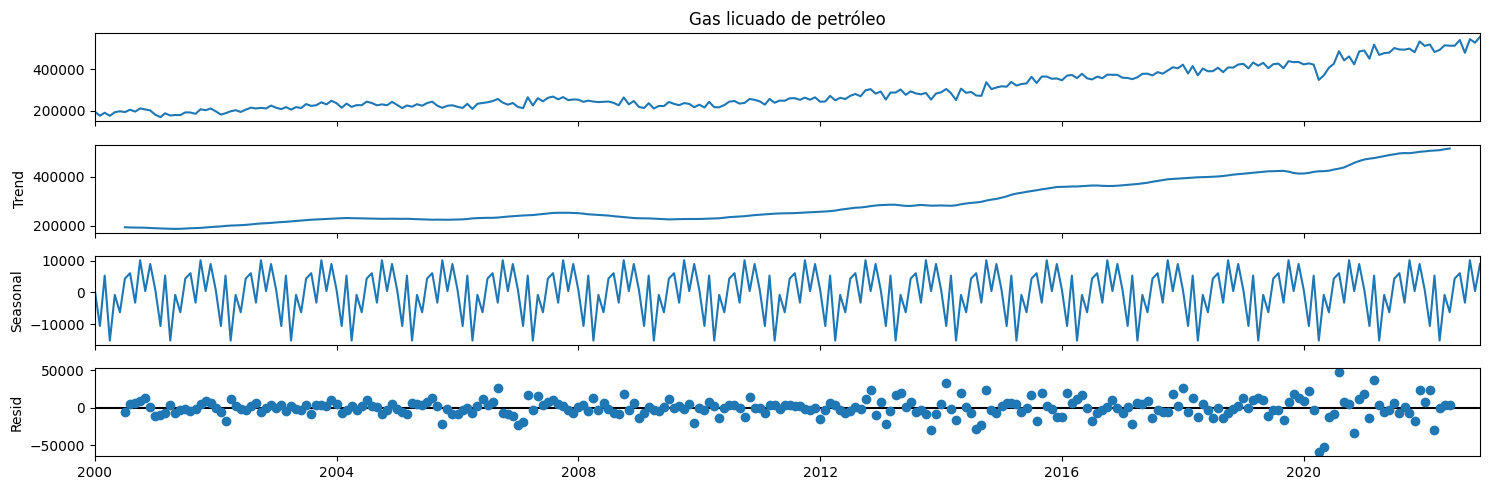

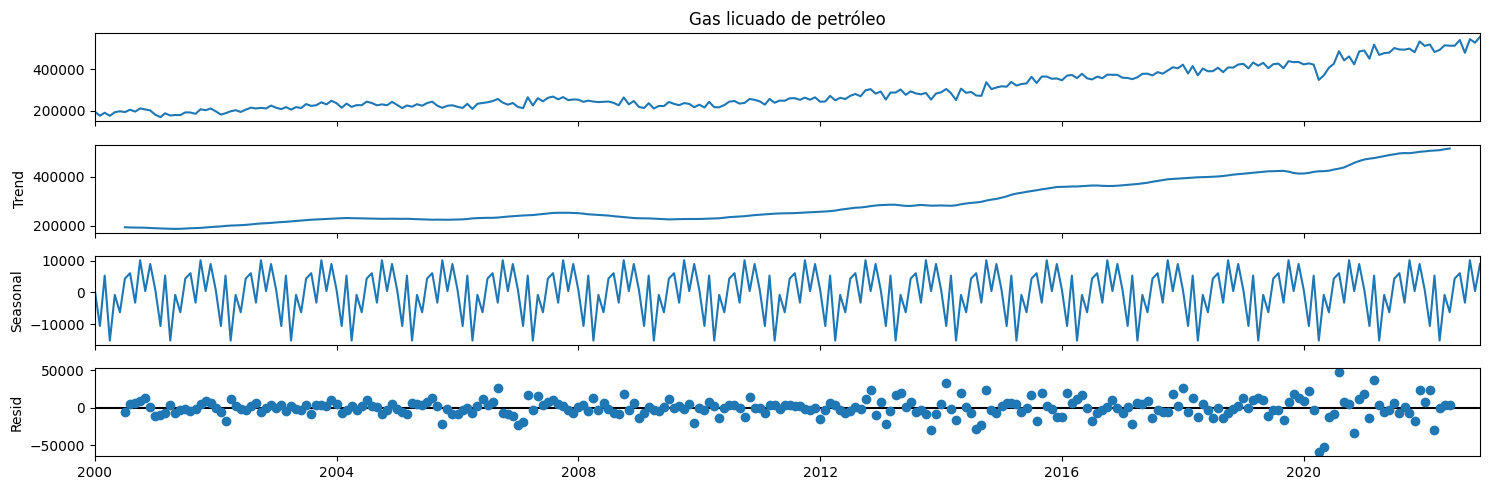

In [297]:
descomposicion = seasonal_decompose(train_data["Gas licuado de petróleo"])
descomposicion.plot()

Se puede observar como muestra una tendencia creciente constante. Se puede observar como existe una demanda sostenida y en aumento de gas licuado a lo largo de los años. Se puede observar como si existe una estacionalidad. La varianza de los residuos parece estable, lo que sugiere que el modelo de descomposición ha capturado correctamente la tendencia y la estacionalidad. A pesar de todo ese, se puede concluirq ue no es estacionaria media por la tendencia. No es tacionaria en varianza, porque la amplitur parace crecer levemente en los años.

In [298]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gas licuado de petróleo"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.641345
p-value                        0.999082
# de retardos usados          11.000000
# de observaciones usadas    264.000000
Critical Value (1%)           -3.455365
Critical Value (5%)           -2.872551
Critical Value (10%)          -2.572638
dtype: float64


Se puede observar como el valor de p es bastante alto mayor a 0.05 por lo tanto la hipotesis nula no es estacionaria en media. Aplicamos diferenciacion y logaritmo para ver si alguna hace que se vuelva estacionaria

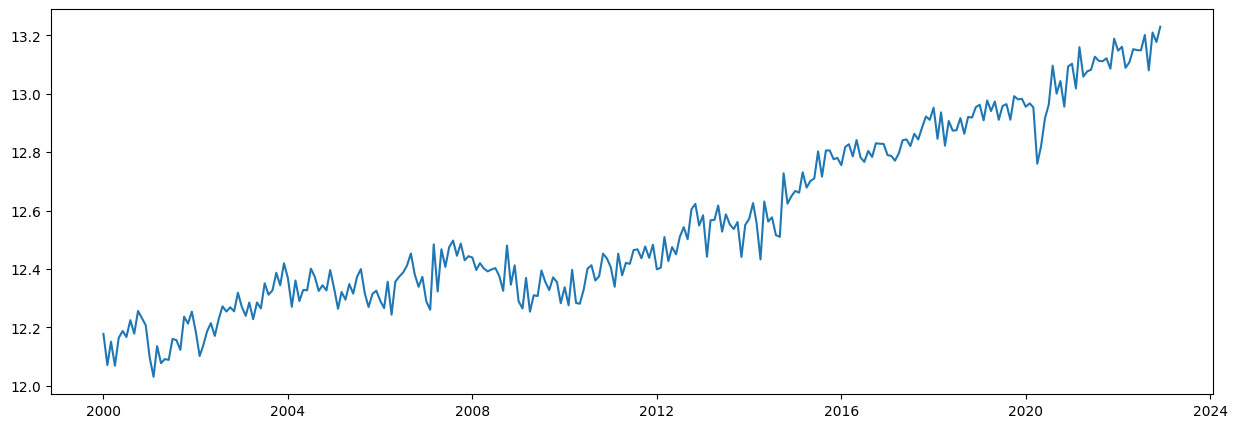

In [299]:
ts_air_pas_log = np.log(train_data["Gas licuado de petróleo"])
plt.plot(ts_air_pas_log)

In [300]:
# Aplicar logaritmo
ts_log = np.log(train_data["Gas licuado de petróleo"])

# Hacer el test ADF sobre la serie logarítmica directamente
adf_log = adfuller(ts_log.dropna())
print("ADF - Logarítmica")
print(pd.Series(adf_log[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas']))


ADF - Logarítmica
Estadístico de prueba          0.547870
p-value                        0.986258
# de retardos usados          14.000000
# de observaciones usadas    261.000000
dtype: float64


In [301]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gas licuado de petróleo"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.441399
p-value                        0.009626
# de retardos usados          16.000000
# de observaciones usadas    258.000000
Critical Value (1%)           -3.455953
Critical Value (5%)           -2.872809
Critical Value (10%)          -2.572775
dtype: float64


con una diferencia es estacionaria en media

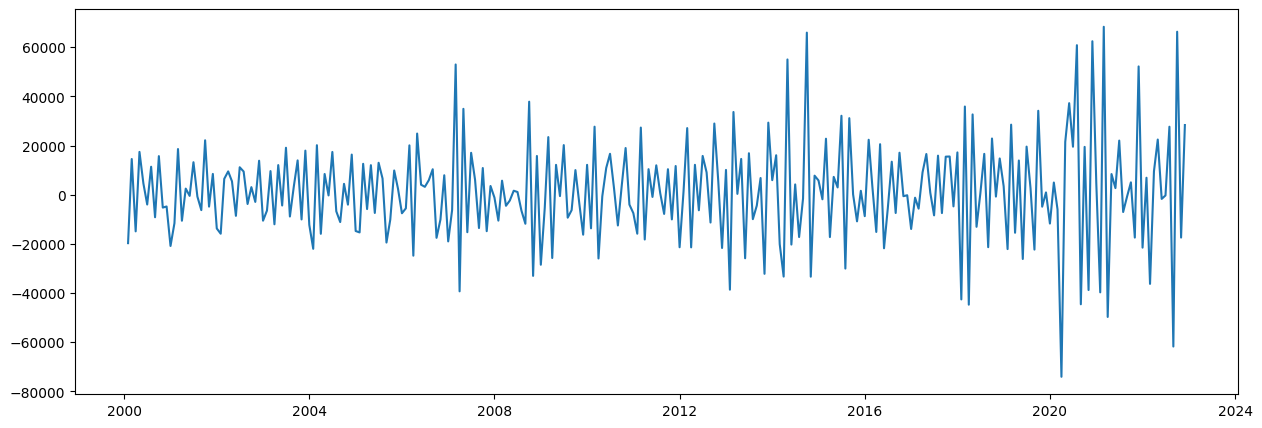

In [302]:
plt.plot(ts_air_pas_diff)

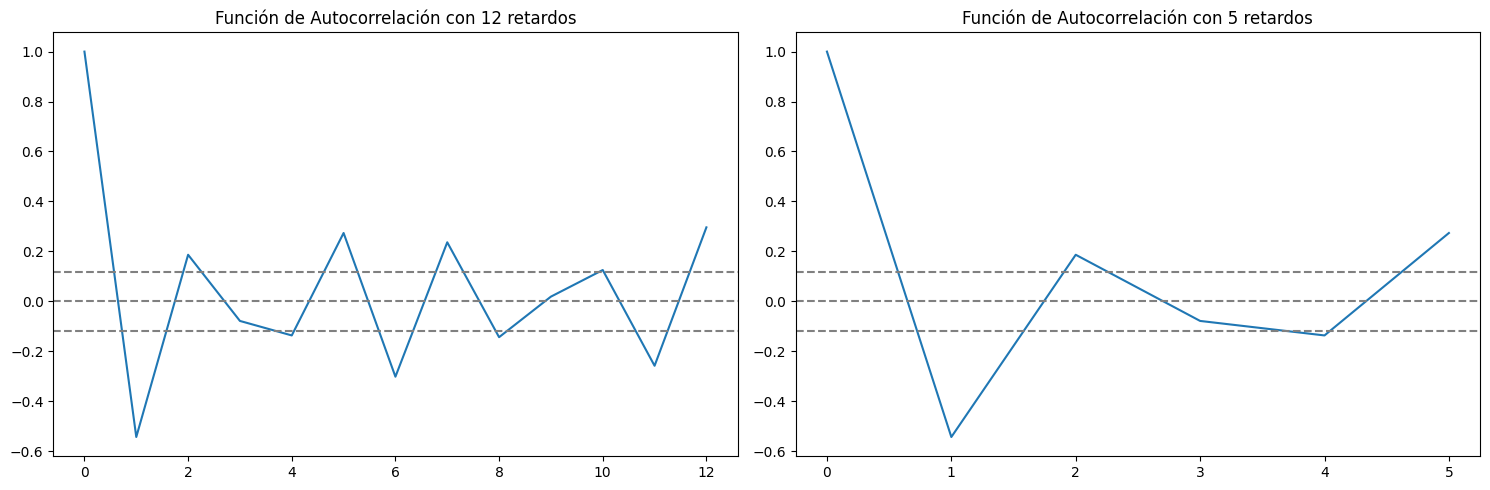

In [303]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_air_pas_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_air_pas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

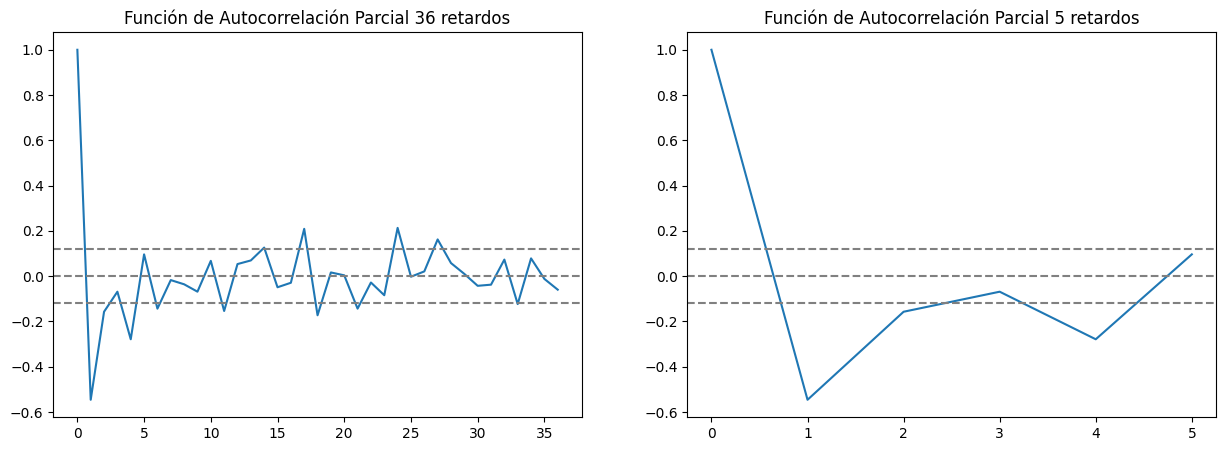

In [304]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_air_pas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_air_pas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

p = 1, q = 1. p = 2, q = 2 y d = 1

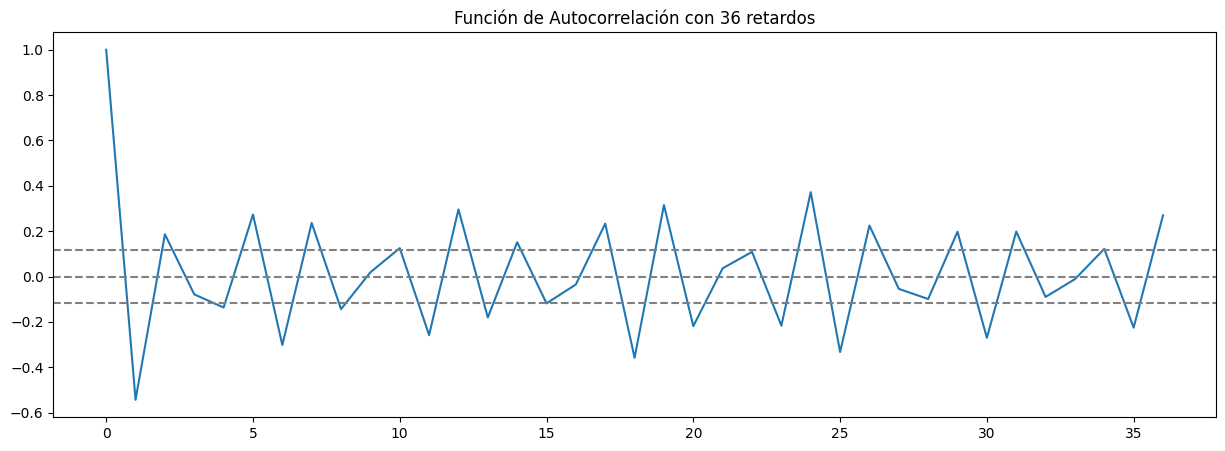

In [305]:
plt.plot(acf(ts_air_pas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Es estacionaria en 12 meses

In [306]:
ts_air_pas_diff_D = ts_air_pas_diff.diff(12)
ts_air_pas_diff_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

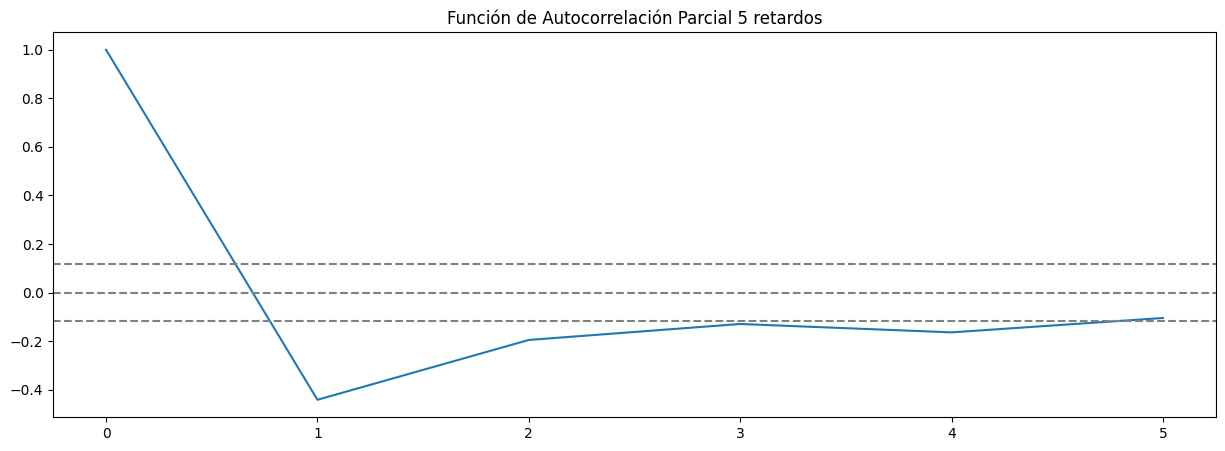

In [307]:
plt.plot(pacf(ts_air_pas_diff_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


In [308]:
modelo_sarima = SARIMAX(
    ts_air_pas_diff,
    order=(1, 1, 1),                 # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 12),    # SARIMA(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_sarima.fit()

print(resultado_sarima.summary().tables[1])

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4333      0.121     -3.584      0.000      -0.670      -0.196
ma.L1         -0.9724      0.041    -23.447      0.000      -1.054      -0.891
ar.S.L12      -0.1089      0.186     -0.586      0.558      -0.473       0.255
ma.S.L12      -0.8097      0.139     -5.809      0.000      -1.083      -0.536
sigma2      6.609e+08   1.16e-10    5.7e+18      0.000    6.61e+08    6.61e+08


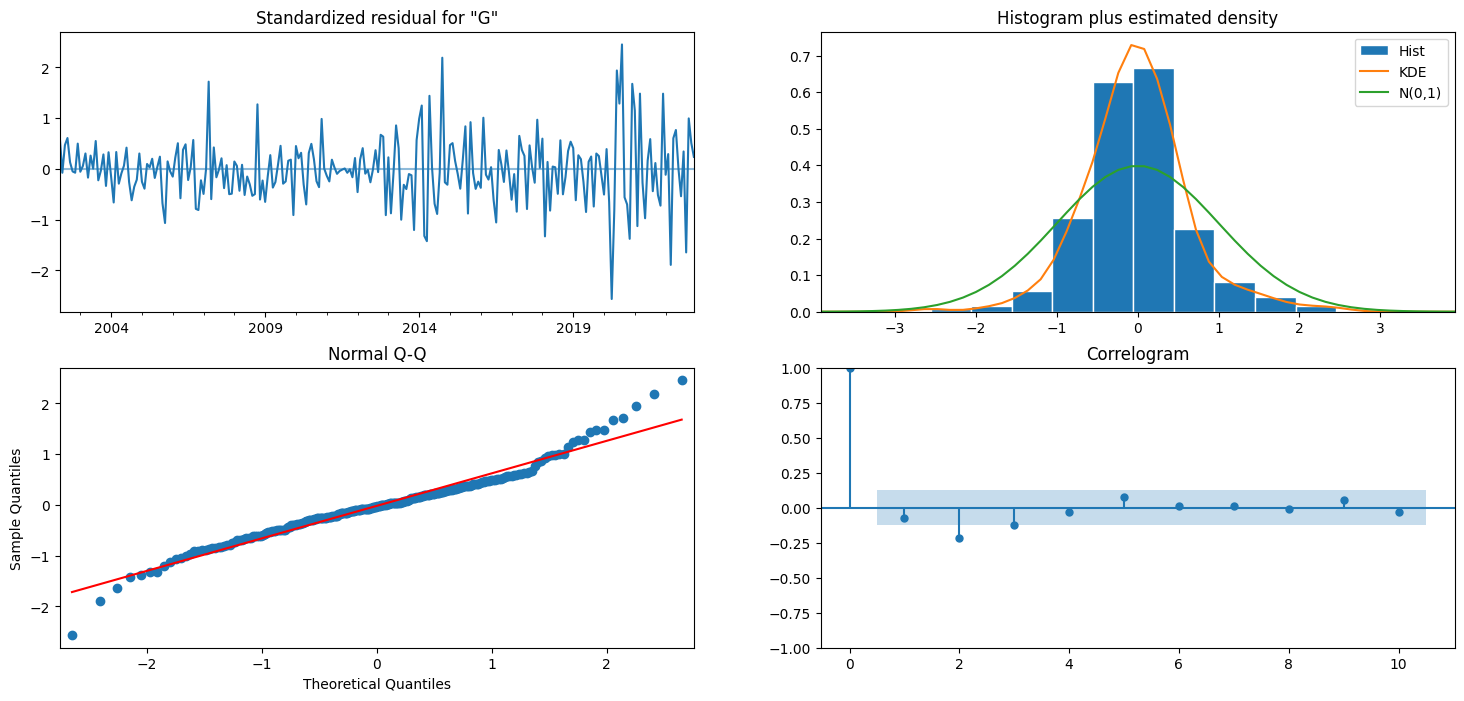

In [309]:
resultado_sarima.plot_diagnostics(figsize=(18, 8))
plt.show()

In [310]:
modelo_2 = SARIMAX(
    ts_air_pas_diff,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_2 = modelo_2.fit()
print("Modelo SARIMA(2,1,0)(1,1,1,12)")
print(resultado_2.summary().tables[1])

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMA(2,1,0)(1,1,1,12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1149      0.187      0.615      0.539      -0.251       0.481
ar.L2          0.0402      0.158      0.254      0.800      -0.270       0.350
ma.L1         -1.6555      0.181     -9.163      0.000      -2.010      -1.301
ma.L2          0.6851      0.184      3.731      0.000       0.325       1.045
ar.S.L12      -0.1590      0.166     -0.955      0.340      -0.485       0.167
ma.S.L12      -0.7942      0.128     -6.194      0.000      -1.045      -0.543
sigma2      5.346e+08    3.9e-10   1.37e+18      0.000    5.35e+08    5.35e+08


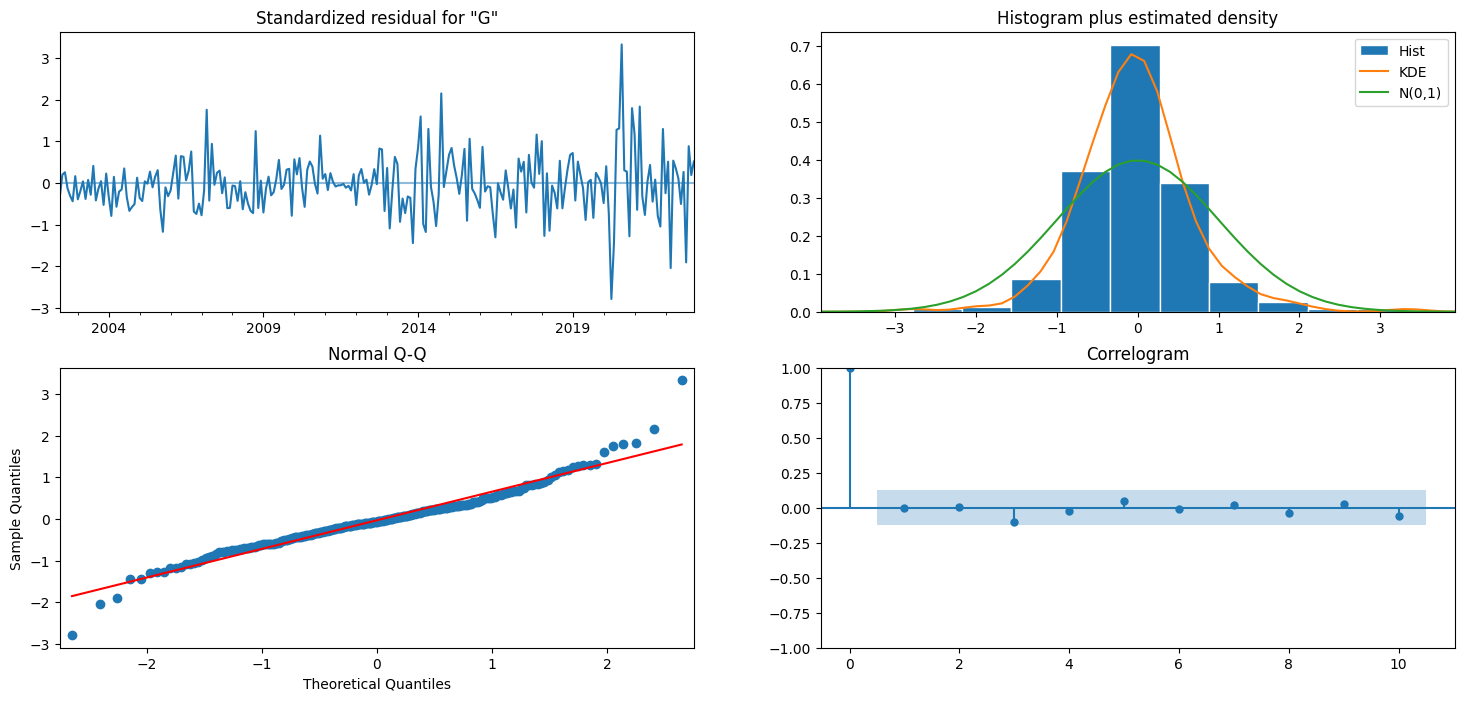

In [311]:
resultado_2.plot_diagnostics(figsize=(18, 8))
plt.show()

In [312]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1=",resultado_sarima.aic)
print("Modelo 2=",resultado_2.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1=",resultado_sarima.bic)
print("Modelo 2=",resultado_2.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1= 5606.220853145627
Modelo 2= 5549.758167189106
Resultados de BIC (Bayesian information criterion)
Modelo 1= 5623.787996876452
Modelo 2= 5574.323885545502


In [313]:
hoja_df_2025 = pd.read_excel("./data/VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gas licuado de petróleo"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)

test_data.index[0]

Timestamp('2023-01-01 00:00:00')

In [314]:
# Obtener predicciones desde el modelo
pred = resultado_2.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_diff = pred.predicted_mean

# Reconstruir valores originales sumando las diferencias al último valor conocido del train
last_train_value = train_data["Gas licuado de petróleo"].iloc[-1]
predicted_real = pred_diff.cumsum() + last_train_value


In [315]:
comparison_df = pd.DataFrame({
    "Real": test_data["Gas licuado de petróleo"],
    "Predicción (SARIMA)": predicted_real
})
comparison_df

,Real,Predicción (SARIMA)
2023-01-01,574148.00,548723.221438
2023-02-01,497273.19,535400.388065
2023-03-01,588892.16,557929.106132
2023-04-01,513919.89,527259.483480
2023-05-01,561767.17,546135.811932
2023-06-01,532138.90,546156.264071
2023-07-01,521833.56,559966.587401
2023-08-01,543825.64,572332.749666
2023-09-01,517699.48,557959.552640
2023-10-01,495261.14,579338.118254


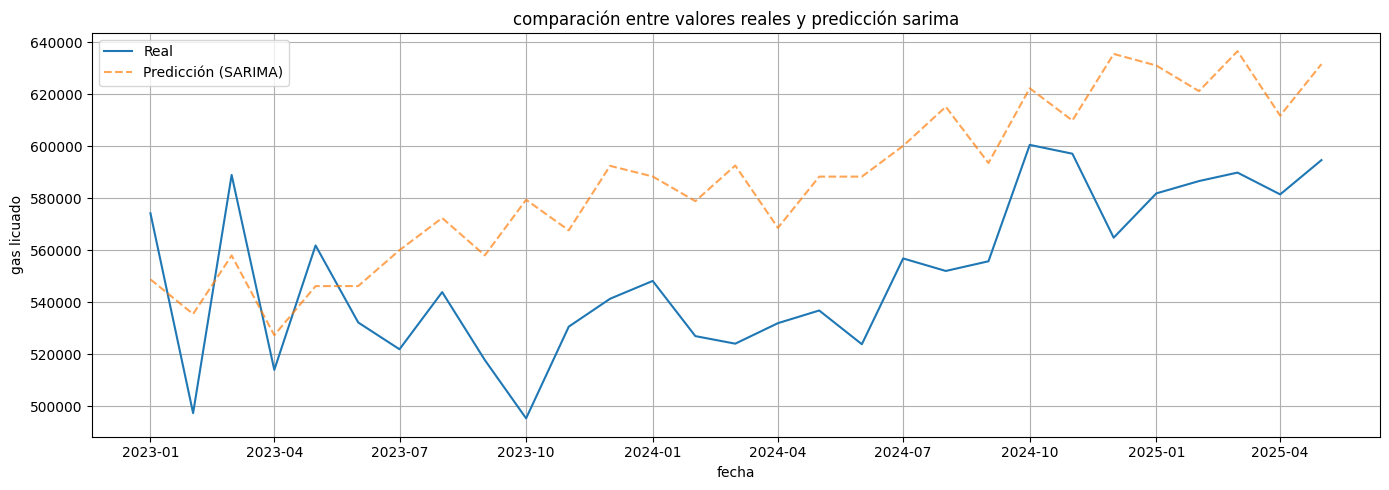

In [316]:
# asegúrate de que el índice sea tipo datetime para graficar correctamente
comparison_df.index = pd.to_datetime(comparison_df.index)

# graficar
plt.figure(figsize=(14, 5))
plt.plot(comparison_df["Real"], label="Real")
plt.plot(comparison_df["Predicción (SARIMA)"], label="Predicción (SARIMA)", linestyle="--", alpha=0.7)
plt.title("comparación entre valores reales y predicción sarima")
plt.xlabel("fecha")
plt.ylabel("gas licuado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


La predicción mantiene una tendencia creciente, pero tiende a sobreestimar los valores reales consistentemente, especialmente hacia el final del horizonte de predicción.No capta bien los picos y valles (variabilidad mensual), por lo que parece muy suavizado.

**Prophet**

In [321]:
from prophet import Prophet
import pandas as pd

df_prophet = train_data.reset_index().rename(columns={"Fecha": "ds", "Gas licuado de petróleo": "y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = pd.DataFrame(test_data.index)
future.columns = ['ds']
forecast = model_prophet.predict(future)

pred_prophet = forecast[['ds', 'yhat']].set_index("ds")["yhat"]


17:30:49 - cmdstanpy - INFO - Chain [1] start processing


17:30:49 - cmdstanpy - INFO - Chain [1] done processing


In [322]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar modelo HW
hw_model = ExponentialSmoothing(train_data["Gas licuado de petróleo"], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

pred_hw = hw_fit.forecast(steps=len(test_data))
pred_hw.index = test_data.index  

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [323]:
# Normalizar la serie
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[["Gas licuado de petróleo"]])

# Función para crear dataset supervisado
def create_supervised(data, lag=12):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Configurar rezago
lag = 12
X_train, y_train = create_supervised(scaled_train, lag)

from sklearn.pipeline import Pipeline

# Definir el pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

# Hiperparámetros a evaluar
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001]
}

# Ejecutar GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
grid.fit(X_train, y_train)

# Mostrar el mejor modelo
print("Mejores hiperparámetros:", grid.best_params_)


# Predecir paso a paso para todo el período de test
last_input = scaled_train[-lag:].reshape(1, -1)
pred_scaled = []

best_model = grid.best_estimator_

for _ in range(len(test_data)):
    next_scaled = best_model.predict(last_input)[0]
    pred_scaled.append(next_scaled)
    last_input = np.append(last_input[:, 1:], [[next_scaled]], axis=1)

# Inversión del escalado
pred_mlp = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).flatten()
pred_mlp = pd.Series(pred_mlp, index=test_data.index)


comparison_df["MLP (Scikit-learn)"] = pred_mlp

# MAE del nuevo modelo
from sklearn.metrics import mean_absolute_error
print("MAE MLP (Scikit-learn):", mean_absolute_error(comparison_df["Real"], comparison_df["MLP (Scikit-learn)"]))



Mejores hiperparámetros: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__solver': 'adam'}
MAE MLP (Scikit-learn): 22976.645194782945


In [324]:
from sklearn.metrics import mean_absolute_error

comparison_df = pd.DataFrame({
    "real": test_data["Gas licuado de petróleo"],
    "prophet": pred_prophet,
    "holt-winters": pred_hw,
    "mlp (neuronal)": pred_mlp
})

print(comparison_df)


print("mae prophet:", mean_absolute_error(comparison_df["real"], comparison_df["prophet"]))
print("mae holt-winters:", mean_absolute_error(comparison_df["real"], comparison_df["holt-winters"]))
print("mae mlp:", mean_absolute_error(comparison_df["real"], comparison_df["mlp (neuronal)"]))


                 real        prophet   holt-winters  mlp (neuronal)
2023-01-01  574148.00  520575.461024  538248.859636   547807.918034
2023-02-01  497273.19  513004.751171  526500.958428   546863.826458
2023-03-01  588892.16  526985.316539  541396.342695   532510.877395
2023-04-01  513919.89  510603.767220  523097.907229   525902.487436
2023-05-01  561767.17  531103.668034  540666.177816   534305.085015
2023-06-01  532138.90  523304.534792  537823.119366   538823.407648
2023-07-01  521833.56  540446.128736  549566.041665   531699.552875
2023-08-01  543825.64  538131.823304  556121.762779   554465.300907
2023-09-01  517699.48  534124.742791  544379.340418   514209.192300
2023-10-01  495261.14  551363.333829  565569.223616   544021.975944
2023-11-01  530542.42  544246.777993  556523.097752   543105.191701
2023-12-01  541263.18  553349.069196  569903.716564   550574.863804
2024-01-01  548124.45  545430.236769  562398.163397   557294.585310
2024-02-01  526897.85  541571.869428  550650.262

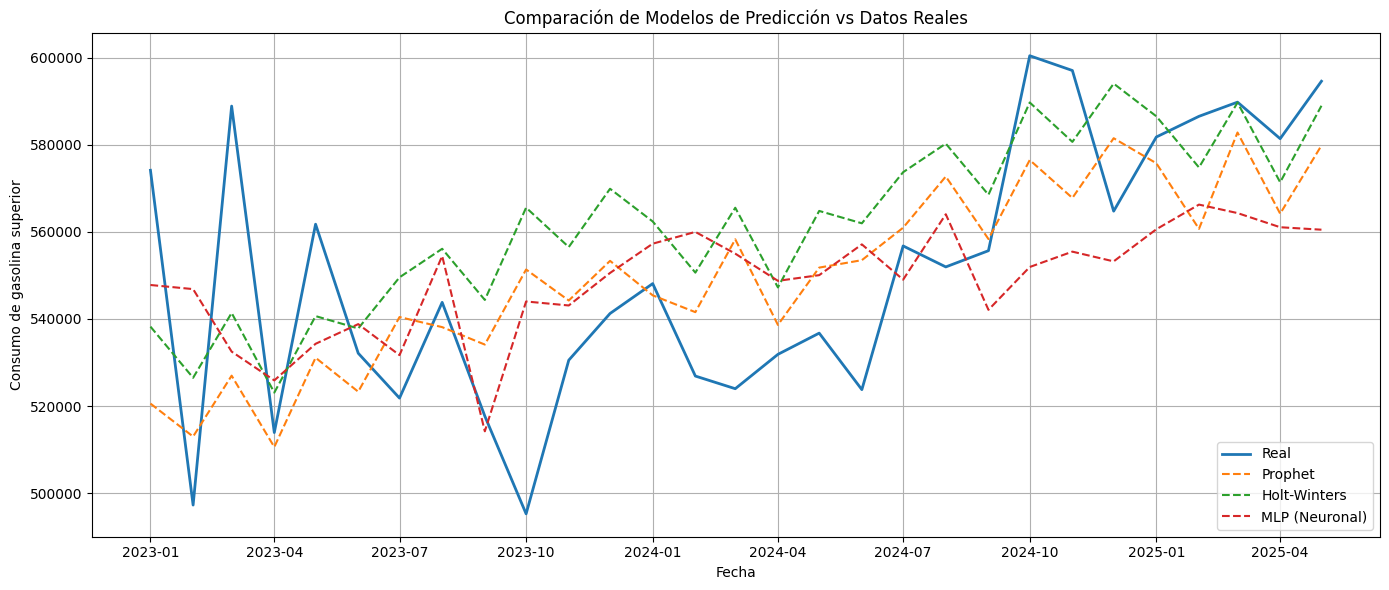

In [330]:
# Asegurarte de que el índice sea de tipo datetime para una buena visualización
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 6))

plt.plot(comparison_df["real"], label="Real", linewidth=2)
plt.plot(comparison_df["prophet"], label="Prophet", linestyle="--")
plt.plot(comparison_df["holt-winters"], label="Holt-Winters", linestyle="--")
plt.plot(comparison_df["mlp (neuronal)"], label="MLP (Neuronal)", linestyle="--")

plt.title("Comparación de Modelos de Predicción vs Datos Reales")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Conclusiones 

**Prophet**: Captura mejor los patrones estacionales y muestra una evolución similar a la serie real, aunque también suaviza un poco.

**Holt-Winters**: Es el que más se alinea visualmente con la tendencia y variación de los datos reales. Captura los ascensos y descensos más parecidos a la serie real.

**Red neuronal**: Tiene una respuesta más segmentada y brusca. Aunque mejora sobre algunos puntos, tiende a subestimar valores altos y no refleja bien la estacionalidad.

## Conclusiones Generales

1. Los sucesos de Pandemia por Covid-19 y Guerra de Ucranía tuvieron efectos negativos sobre la calidad de estudio de estacionalidad de los precios de la Gasolina Super, al mostrar valles y picos anómalos respectivamente. Se recomienda hacer una estudio tomando en cuenta más años para miticar el efecto de ambos eventos.

2. Para el precio de gasolina Super, el mejor modelo fueron redes neuronales (AIC = -257.80, BI = 235.65) y prophet (AIC = -257.80, BIC = 235.65), en todos los caso los datos fueron transformados con boxcox antes de ser analizados.